In [1]:
suppressPackageStartupMessages({
    library(Seurat)
    library(SCP)
    library(SeuratDisk)
    #library(SeuratData)
    library(patchwork)
    library(ggplot2)
    library(cowplot)
    #theme_set(theme_cowplot())
    library(Matrix)
    #library(SeuratWrappers)
    library(dplyr)
    #library(reticulate)
    #library(MAST)
    #library(velocyto.R)
    #library(monocle3)
    #library(magrittr)
    library(RColorBrewer)
    library(dittoSeq)
    library("clusterProfiler")
    library("org.Hs.eg.db")
    library("AnnotationHub")
})
options(warn=-1)

set.seed(23)

setwd("/work3/SingleCell/Arima")
options(stringsAsFactors = F)
source("src/functions_nagai.R")

# DEG identification amongst the samples (ALL CELLS)

Here we use pairwise comparison between samples:

1. Pre1: control and hormone
2. Pre1_hormone and EMO6_hormone
3. Pre1_control and Pre1_hor + EMO6_hor

In [2]:
ari_org_integrated <- readRDS("data/ari_org/ari_org_annotated.rds")

In [3]:
table(ari_org_integrated$celltype)


           NH         LGR5+       Surface       Stromal     Glandular 
         4009          2389          2710          1657          1654 
      PV-like       Luminal Proliferative      Ciliated            10 
         1387          1262           816           682           426 
         Endo            13 
          336           209 

In [4]:
Idents(object = ari_org_integrated) <- ari_org_integrated$project

In [5]:
DefaultAssay(ari_org_integrated) <- "SCT"

In [6]:
ari_org_integrated <- PrepSCTFindMarkers(ari_org_integrated)

Minimum UMI unchanged. Skipping re-correction.



In [7]:
# DEG all clusters
Idents(object = ari_org_integrated) <- ari_org_integrated$celltype
ari.markers <- FindAllMarkers(ari_org_integrated, assay = "SCT", min.pct = 0.25, logfc.threshold = 0.25,
                                verbose = FALSE)

In [ ]:
# For each cluster make this plot

ari.markers %>%
    group_by(cluster) %>%
    slice_max(n = 5, order_by = avg_log2FC)

In [ ]:
top200 <- ari.markers %>% 
                group_by(cluster) %>% 
                filter(p_val_adj < 0.05) %>% 
                arrange(avg_log2FC) %>%
                top_n(n = 200, wt = avg_log2FC)

## FigS4_D (name has changed from C to D)

In [ ]:
ari.markers %>%
    group_by(cluster) %>%
    top_n(n = 5, wt = avg_log2FC) -> top5

plot.width = 15
plot.height = 15
options(repr.plot.width = plot.width, repr.plot.height = plot.height)
DoHeatmap(ari_org_integrated, features = top5$gene, raster = FALSE) + theme(axis.text = element_text(size = 16)) + NoLegend()
ggsave(file="results/2023-07-06_Revision1/FigS4_D.pdf", width = plot.width, height = plot.height, dpi = 300) 

# To check hormone-dependent response of stromal and PV-like cells:

In [ ]:
# save DEG list
write.table(as.matrix(ari.markers), 
            'results/2023-07-06_Revision1/DEGs_ari_org_per_clusters.tsv', 
            sep = '\t', row.names = F, col.names = T, quote = F)

In [8]:
final_color_palette <- c('#1B9E77','#D95F02','#7570B3',
                         '#E7298A','#66A61E','#E6AB02',
                         '#A6761D','#666666','#A6CEE3',
                         '#1F78B4','#B2DF8A','#33A02C',
                         '#FB9A99','#E31A1C','#FDBF6F',
                         '#FF7F00','#CAB2D6','#6A3D9A',
                         '#FFFF99','#B15928')

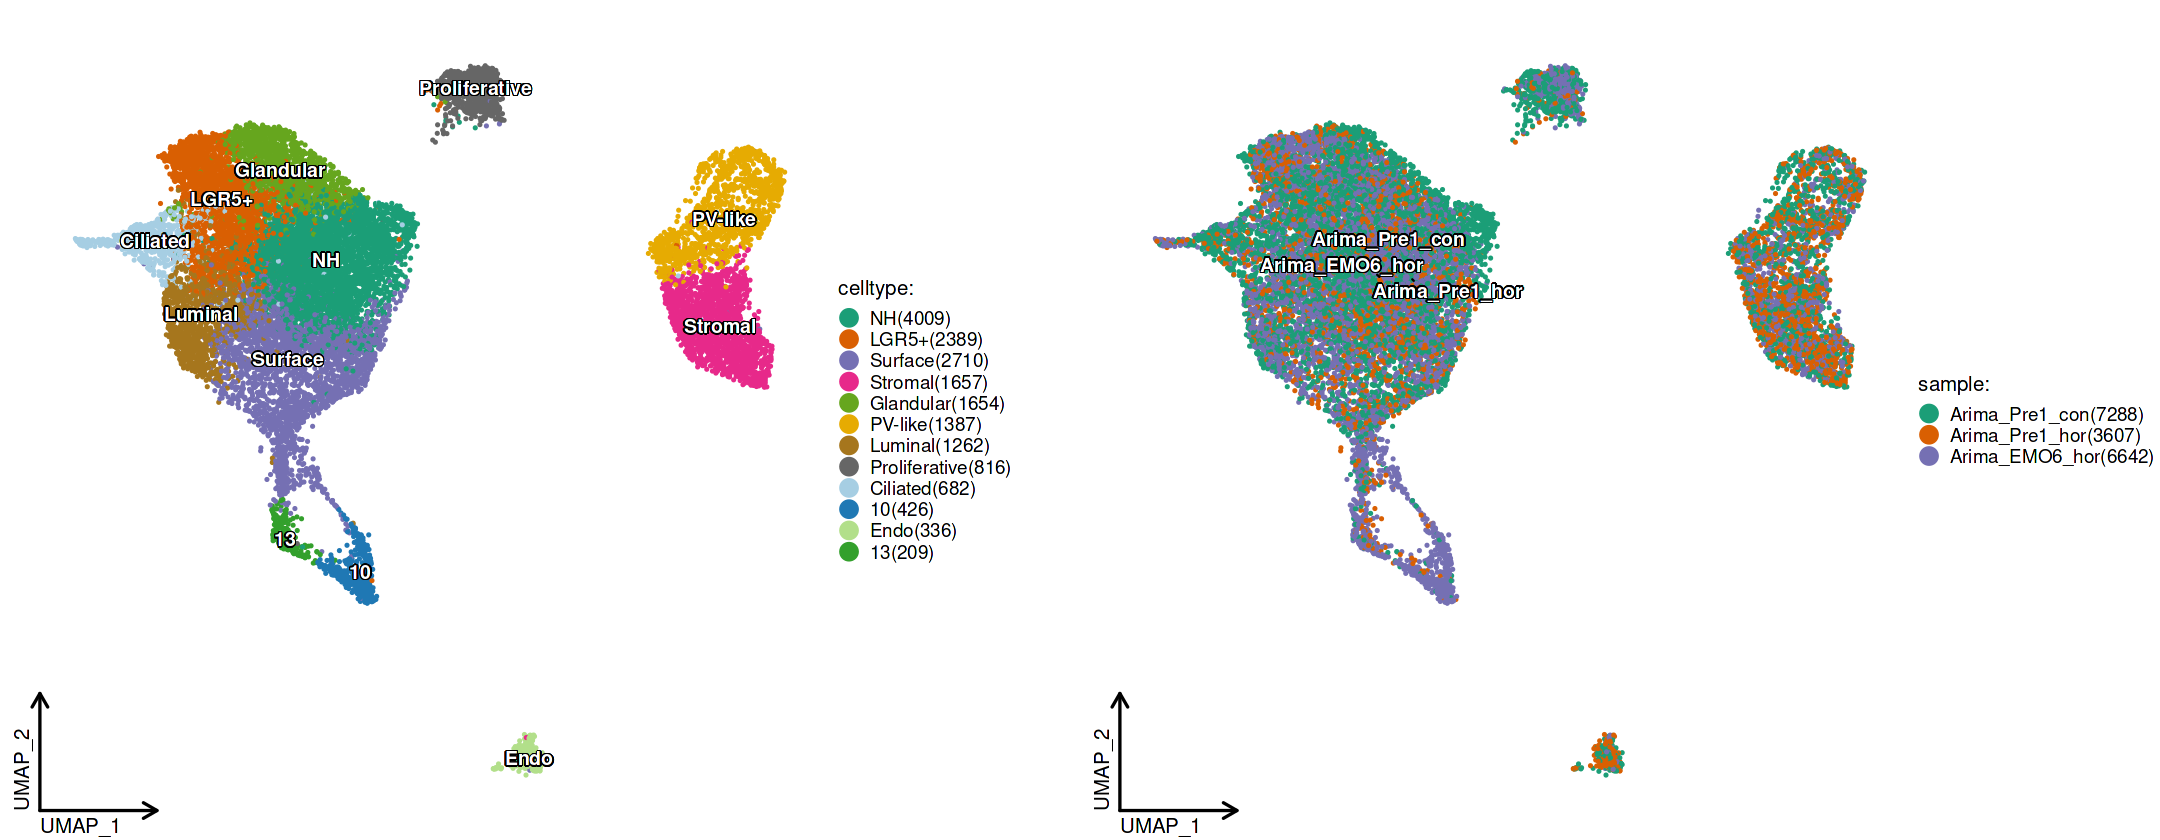

In [9]:
# Using SCP
plot.width = 18
plot.height = 7
options(repr.plot.width = plot.width, repr.plot.height = plot.height)
ClassDimPlot(label_insitu = TRUE, label = TRUE, pt.size = 0.4,
  srt = ari_org_integrated, group.by = c("celltype", "sample"),
  reduction = "UMAP", theme_use = "theme_blank", palcolor = final_color_palette
)

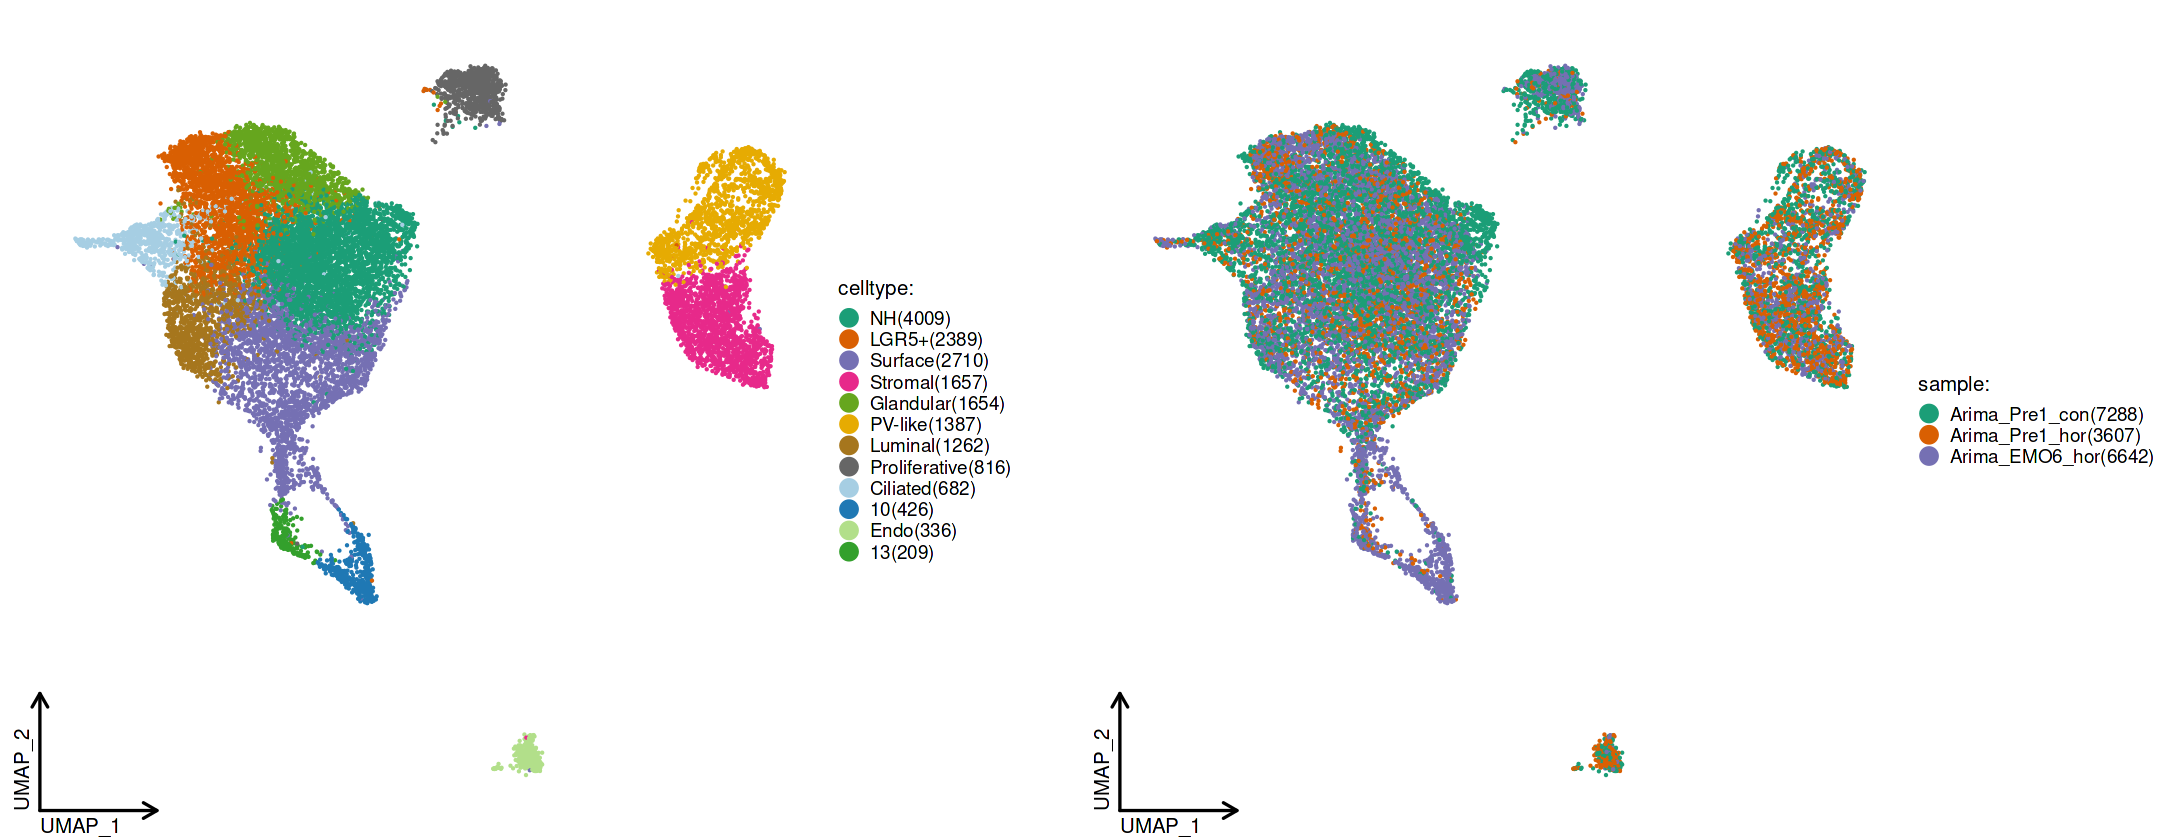

In [10]:
# Using SCP
plot.width = 18
plot.height = 7
options(repr.plot.width = plot.width, repr.plot.height = plot.height)
ClassDimPlot(label_insitu = TRUE, label = FALSE, 
  srt = ari_org_integrated, group.by = c("celltype", "sample"),
  reduction = "UMAP", theme_use = "theme_blank", palcolor = final_color_palette
)
ggsave(file="results/2023-11-10_Revision2/UMAP_unlabeled.pdf", width = plot.width, height = plot.height)

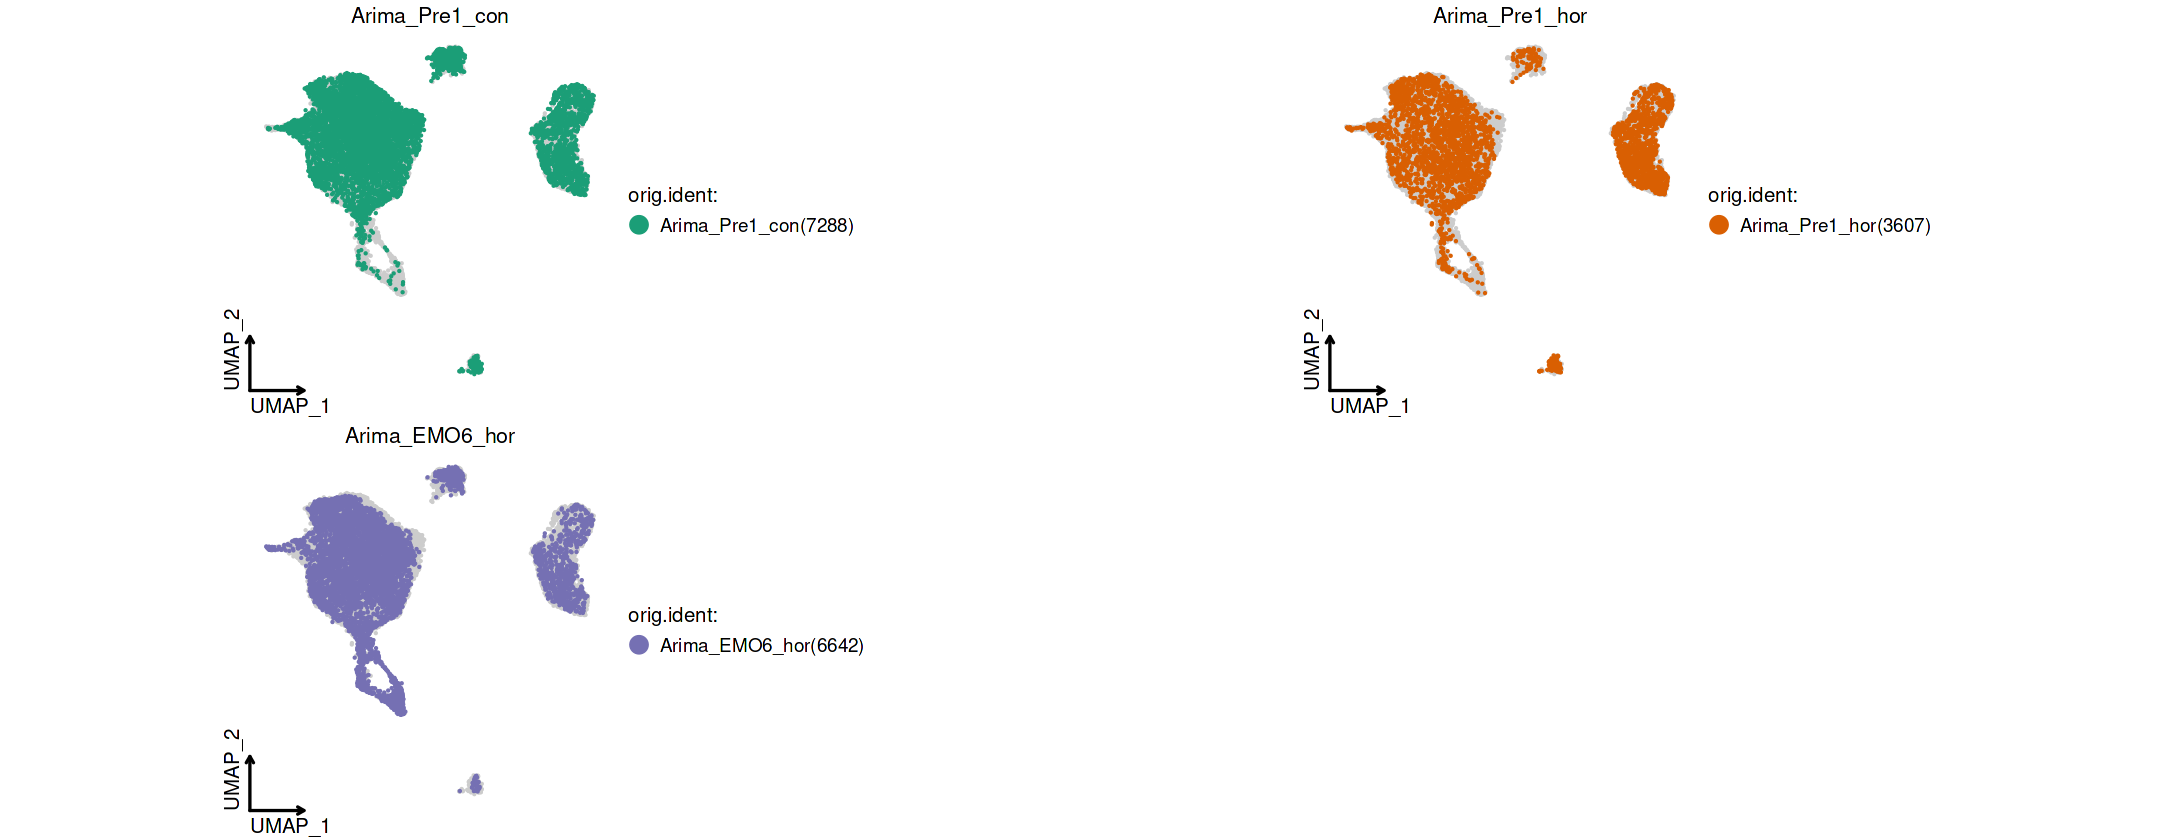

In [12]:
# Using SCP
plot.width = 18
plot.height = 7
options(repr.plot.width = plot.width, repr.plot.height = plot.height)
ClassDimPlot(label_insitu = TRUE, label = FALSE, 
  srt = ari_org_integrated, split.by = "sample",
  reduction = "UMAP", theme_use = "theme_blank", palcolor = final_color_palette
)
ggsave(file="results/2023-11-10_Revision2/UMAP_unlabeled_split.pdf", width = plot.width, height = plot.height)

# Extract DEGs between Pre1_hor vs Pre1_con in stromal and PV-like cells only

In [18]:
Idents(object = ari_org_integrated) <- ari_org_integrated$sample
DefaultAssay(ari_org_integrated) <- "SCT"
hor.markers <- FindMarkers(ari_org_integrated, ident.1 = c("Arima_Pre1_hor","Arima_EMO6_hor"), ident.2 = "Arima_Pre1_con", min.pct = 0.25, logfc.threshold = 0.25,
                                verbose = FALSE)
hor.markers$genes <- rownames(hor.markers)

head(hor.markers, 20)

p_val avg_log2FC pct.1 pct.2 p_val_adj genes     
DHRS3      0     -1.2971840 0.547 0.878 0         DHRS3     
VAV3       0     -0.6463398 0.414 0.675 0         VAV3      
CHRM3      0     -1.4431792 0.151 0.677 0         CHRM3     
KIF26B     0     -0.8877204 0.477 0.777 0         KIF26B    
ALKAL2     0      0.8150104 0.373 0.044 0         ALKAL2    
AC105450.1 0     -0.8706688 0.154 0.457 0         AC105450.1
CAPN13     0     -0.9863324 0.392 0.657 0         CAPN13    
AC012593.1 0      1.3144425 0.410 0.144 0         AC012593.1
TMSB10     0      1.0660697 0.541 0.235 0         TMSB10    
KYNU       0      1.0727959 0.575 0.348 0         KYNU      
LYPD6B     0     -0.8682091 0.395 0.703 0         LYPD6B    
DNAH7      0     -0.8435507 0.393 0.691 0         DNAH7     
PLCL2      0     -0.5374091 0.174 0.436 0         PLCL2     
PTPRG      0     -0.6939745 0.825 0.961 0         PTPRG     
LRIG1      0     -0.9192455 0.676 0.904 0         LRIG1     
PDZRN3     0     -0.8343201 0.421 0.747 0         PDZRN3    
CFAP44     0     -0.6169694 0.368 0.680 0         CFAP44    
NAALADL2   0     -0.7430601 0.417 0.713 0         NAALADL2  
STK32B     0     -0.5784055 0.132 0.388 0         STK32B    
PROM1      0     -0.7657756 0.845 0.961 0         PROM1

In [19]:
# For each cluster make this plot

hor.markers %>%
    slice_max(n = 20, order_by = avg_log2FC)

p_val         avg_log2FC pct.1 pct.2 p_val_adj    genes     
AL356277.3  0.000000e+00 2.469192   0.769 0.477 0.000000e+00 AL356277.3
SERPINB9    0.000000e+00 2.234306   0.316 0.073 0.000000e+00 SERPINB9  
LINC00621   0.000000e+00 2.014463   0.815 0.728 0.000000e+00 LINC00621 
AL079338.1  0.000000e+00 1.859597   0.402 0.061 0.000000e+00 AL079338.1
SLC7A2      0.000000e+00 1.793766   0.639 0.183 0.000000e+00 SLC7A2    
AL357507.1  0.000000e+00 1.457828   0.925 0.908 0.000000e+00 AL357507.1
HIF1A-AS3   0.000000e+00 1.320174   0.831 0.467 0.000000e+00 HIF1A-AS3 
AC012593.1  0.000000e+00 1.314443   0.410 0.144 0.000000e+00 AC012593.1
PTPRM       0.000000e+00 1.235938   0.801 0.489 0.000000e+00 PTPRM     
TXNRD1     3.599464e-103 1.170048   0.624 0.493 9.910403e-99 TXNRD1    
ARHGAP26    0.000000e+00 1.165103   0.914 0.924 0.000000e+00 ARHGAP26  
AL049828.1  1.202508e-65 1.147847   0.598 0.544 3.310865e-61 AL049828.1
ASRGL1      0.000000e+00 1.140134   0.669 0.463 0.000000e+00 ASRGL1    
FTH1        0.000000e+00 1.115189   0.606 0.262 0.000000e+00 FTH1      
ZC3H3       1.096065e-21 1.085636   0.295 0.238 3.017797e-17 ZC3H3     
KYNU        0.000000e+00 1.072796   0.575 0.348 0.000000e+00 KYNU      
TMSB10      0.000000e+00 1.066070   0.541 0.235 0.000000e+00 TMSB10    
UGT2B7      0.000000e+00 1.064398   0.737 0.596 0.000000e+00 UGT2B7    
CERNA2      0.000000e+00 1.051183   0.487 0.151 0.000000e+00 CERNA2    
TFF3        0.000000e+00 1.030687   0.482 0.121 0.000000e+00 TFF3

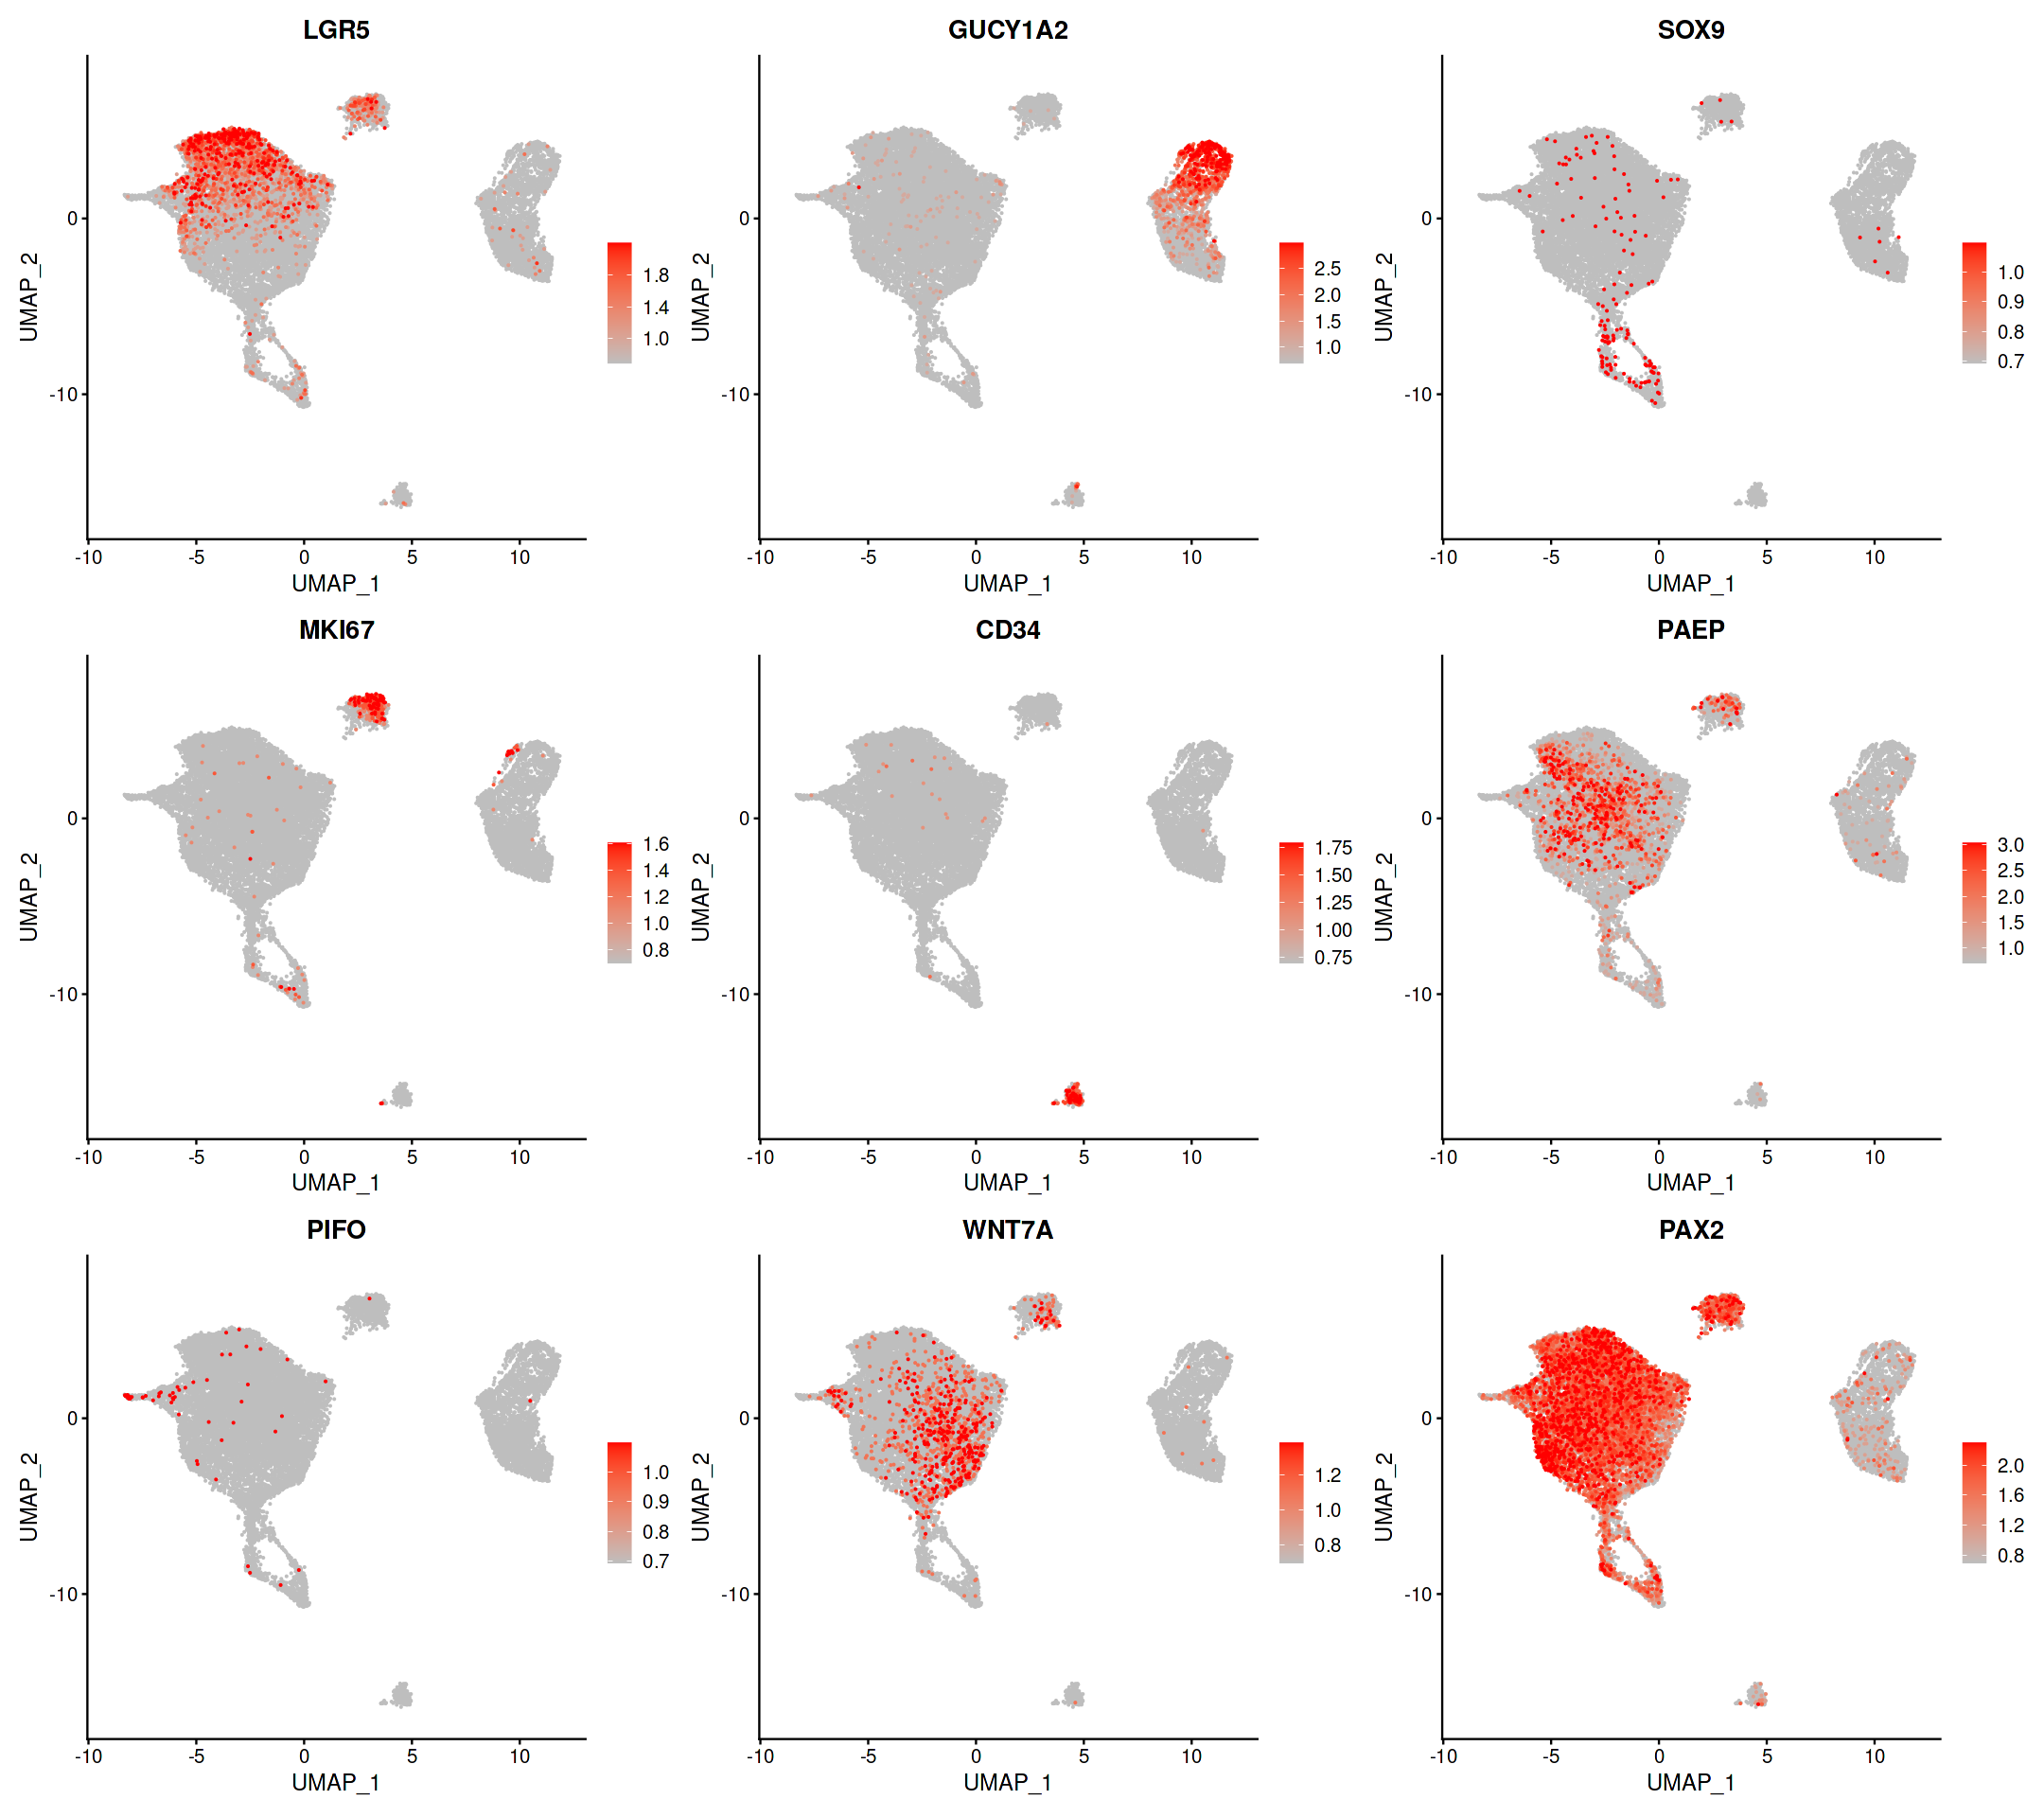

In [13]:
genes_to_plot = c("LGR5", "GUCY1A2", "SOX9", 
                  "MKI67", "CD34", "PAEP", 
                  "PIFO", "WNT7A", "PAX2")

plot.width = 18
plot.height = 16
options(repr.plot.width = plot.width, repr.plot.height = plot.height)
FeaturePlot(ari_org_integrated, features = genes_to_plot, order = TRUE, 
            min.cutoff = 'q5', max.cutoff = 'q95', ncol = 3, cols = c("low" = "grey", "high" = "red"))
ggsave(file="results/2023-11-10_Revision2/Fig.S4C_FeaturePlot.pdf", width = plot.width, height = plot.height)

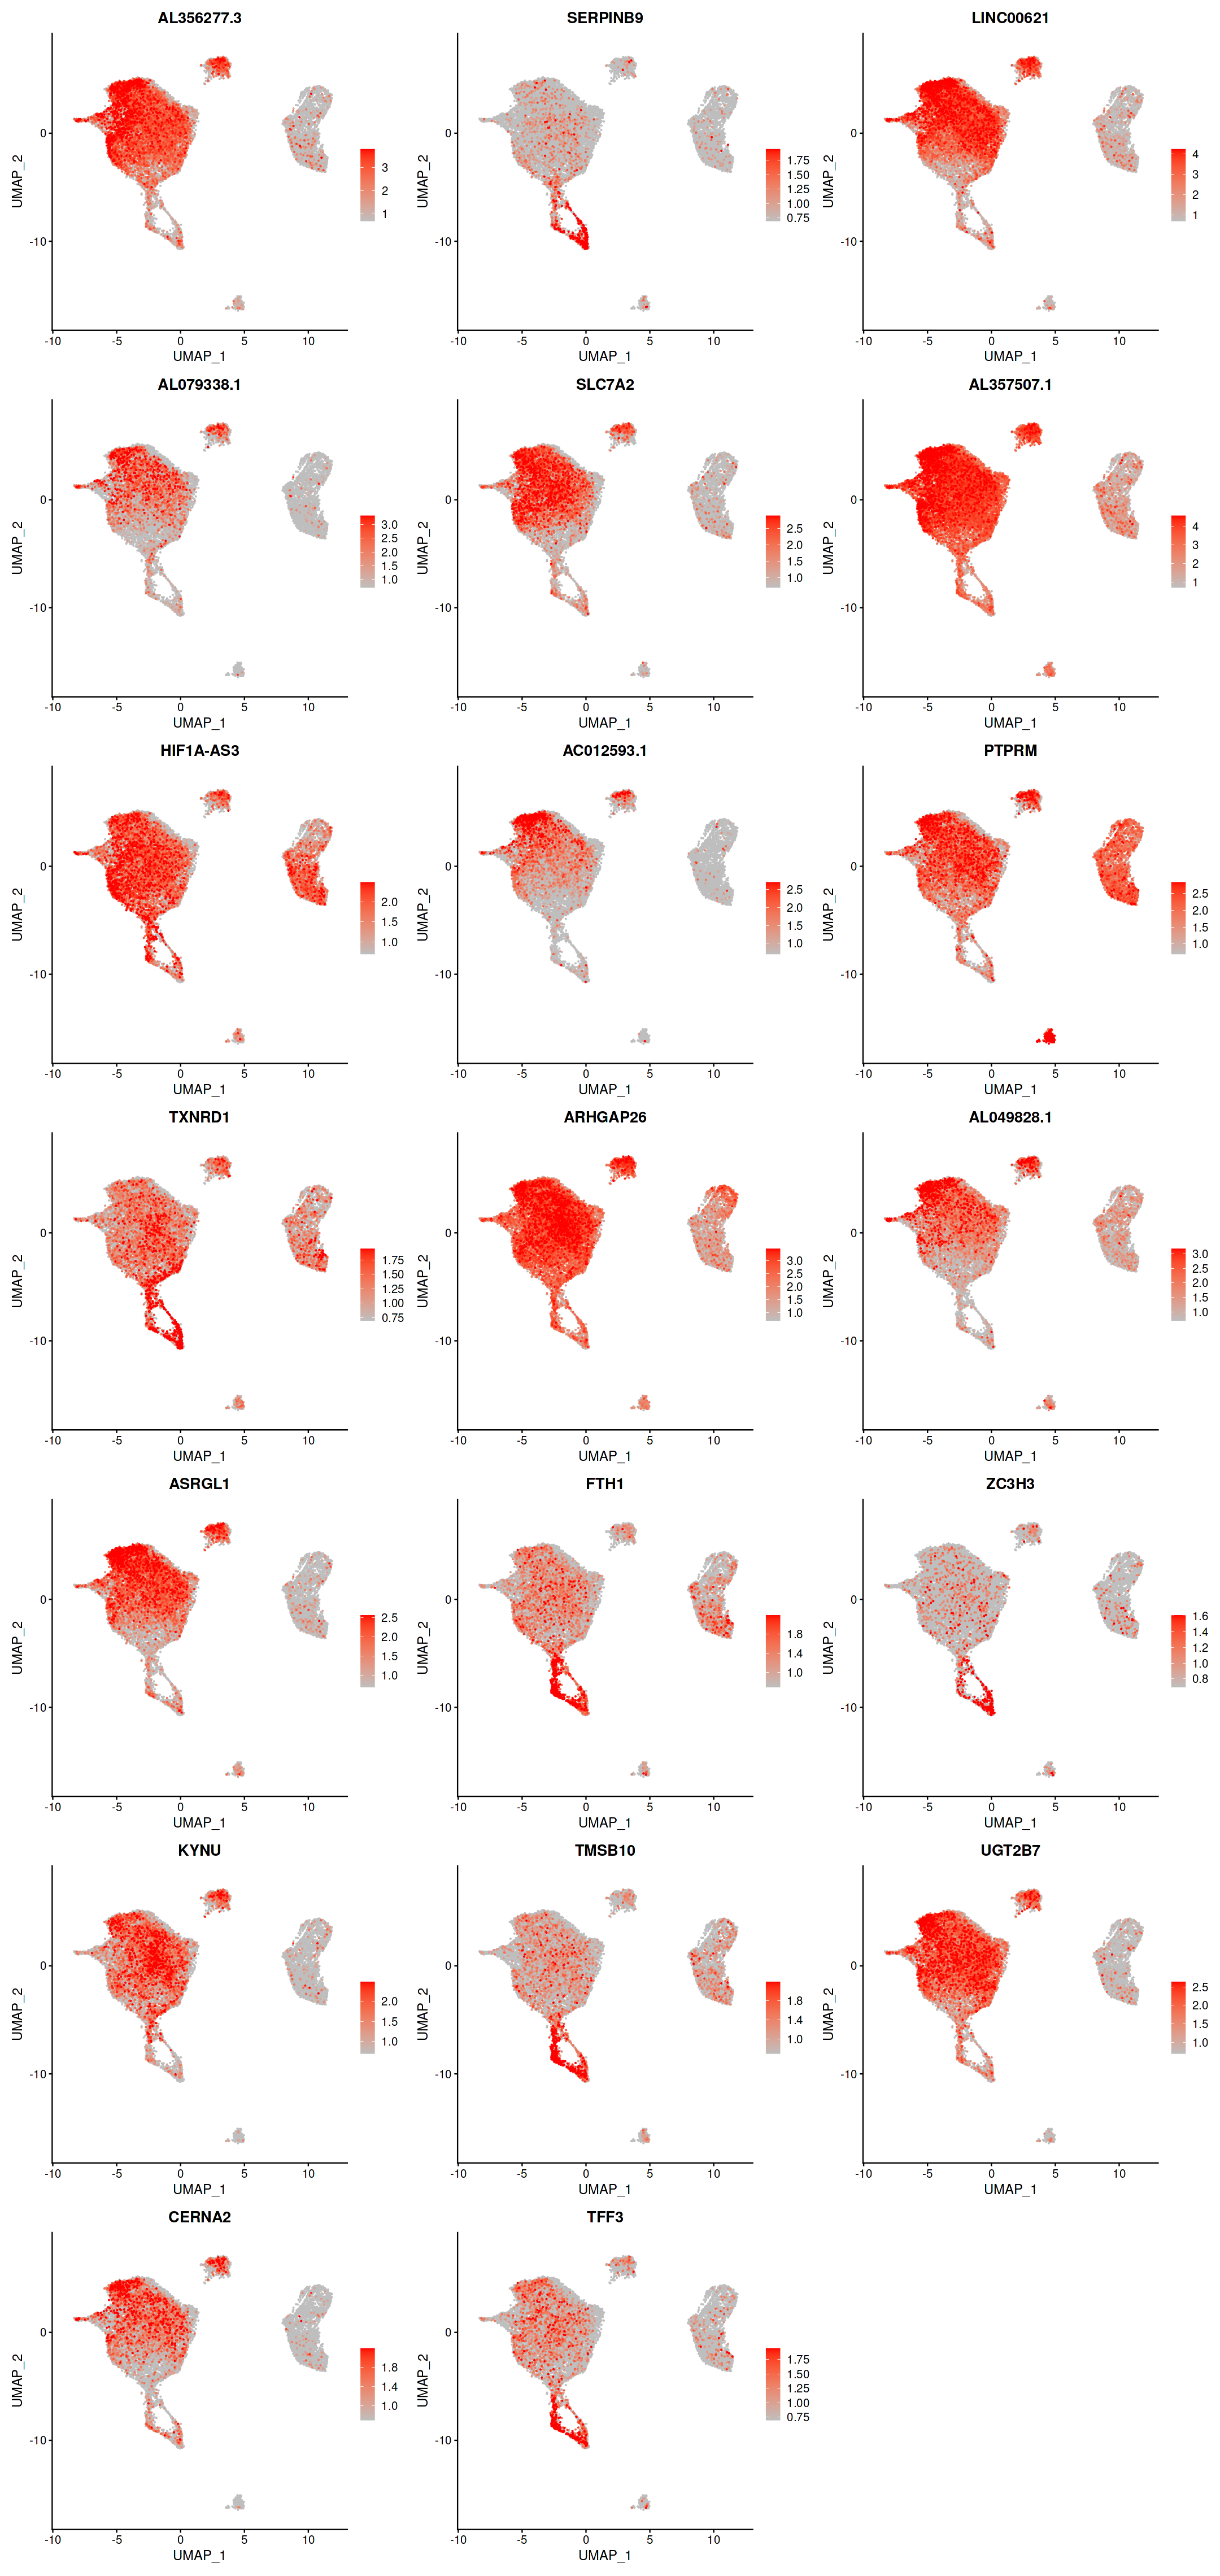

In [32]:
# markers to plot
markers1 = hor.markers %>%
    slice_max(n = 20, order_by = avg_log2FC)

plot.width = 18
plot.height = 38
options(repr.plot.width = plot.width, repr.plot.height = plot.height)
FeaturePlot(ari_org_integrated, features = markers1$genes, order = TRUE, 
            min.cutoff = 'q5', max.cutoff = 'q95', ncol = 3, cols = c("low" = "grey", "high" = "red"))
ggsave(file="results/2023-07-06_Revision1/ari_org_hor_markers_Hor_vs_Con_Pre1_EMO6_umap.pdf", width = plot.width, height = plot.height)

In [21]:
table(ari_org_integrated$celltype)


           NH         LGR5+       Surface       Stromal     Glandular 
         4009          2389          2710          1657          1654 
      PV-like       Luminal Proliferative      Ciliated            10 
         1387          1262           816           682           426 
         Endo            13 
          336           209 

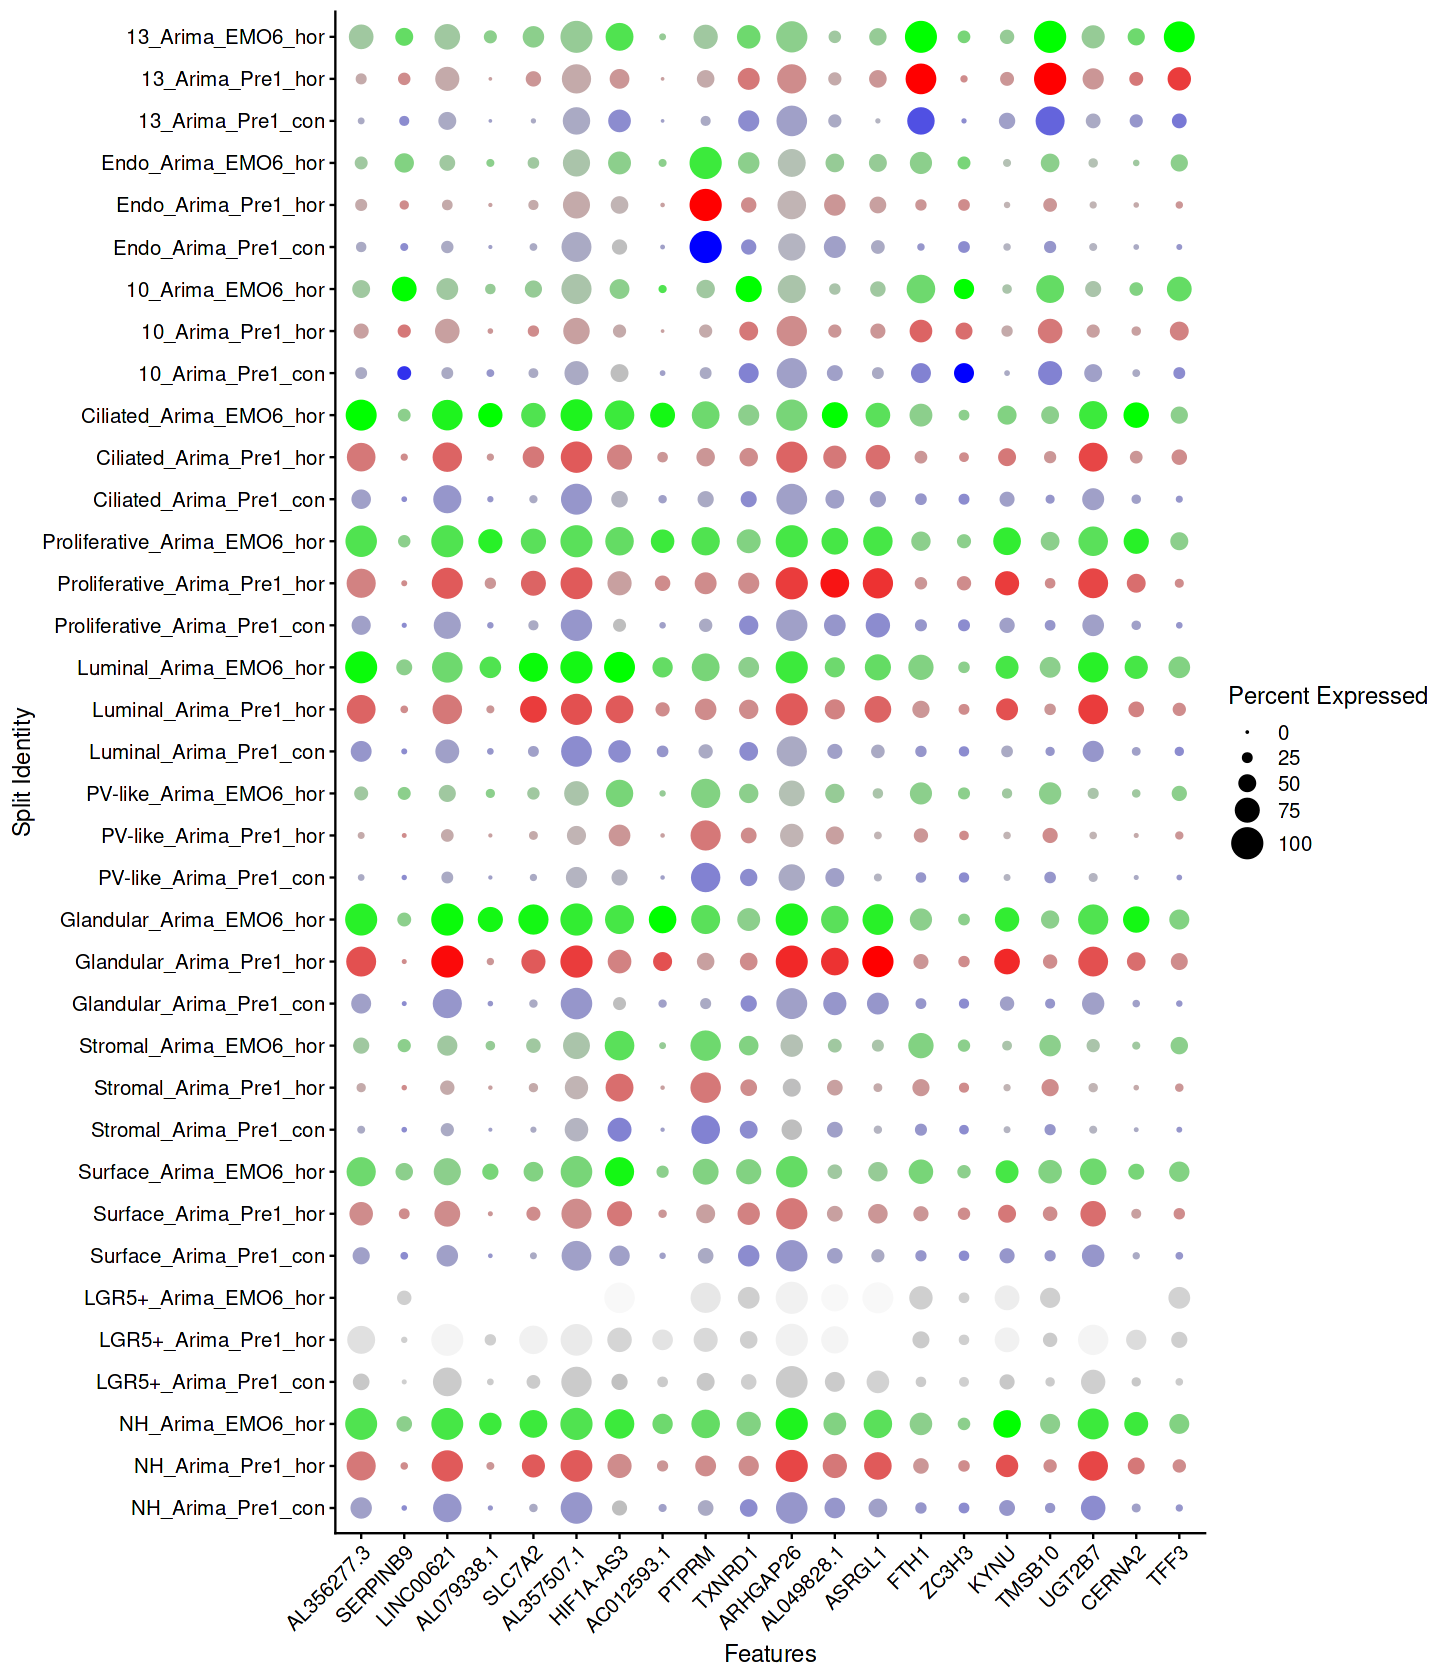

In [33]:
# Dot plots - the size of the dot corresponds to the percentage of cells expressing the
# feature in each cluster. The color represents the average expression level
plot.width = 12
plot.height = 14
options(repr.plot.width = plot.width, repr.plot.height = plot.height)

Idents(ari_org_integrated) <- ari_org_integrated$celltype
DotPlot(ari_org_integrated, features = markers1$genes, cols = c("blue", "red", "green"), dot.scale = 8, split.by = "sample") +
    RotatedAxis()
ggsave(file="results/2023-07-06_Revision1/ari_org_hor_markers_Hor_vs_Con_Pre1_EMO6_dotplot.pdf", width = plot.width, height = plot.height)

In [23]:
# Now compare only between Pre1 con vs hor

Idents(object = ari_org_integrated) <- ari_org_integrated$sample
DefaultAssay(ari_org_integrated) <- "SCT"
hor2.markers <- FindMarkers(ari_org_integrated, ident.1 = "Arima_Pre1_hor", ident.2 = "Arima_Pre1_con", min.pct = 0.25, logfc.threshold = 0.25,
                                verbose = FALSE)

In [24]:
hor2.markers$genes <- rownames(hor2.markers)

head(hor2.markers, 20)

p_val         avg_log2FC pct.1 pct.2 p_val_adj     genes     
DHRS3       0.000000e+00 -1.1787931 0.515 0.878  0.000000e+00 DHRS3     
PROM1       0.000000e+00 -1.0445150 0.708 0.961  0.000000e+00 PROM1     
PLXNA4      0.000000e+00 -1.7798274 0.059 0.474  0.000000e+00 PLXNA4    
ROR2        0.000000e+00 -0.9975723 0.483 0.792  0.000000e+00 ROR2      
ABLIM1      0.000000e+00 -0.8657425 0.640 0.892  0.000000e+00 ABLIM1    
PTPRJ       0.000000e+00 -0.8874483 0.782 0.959  0.000000e+00 PTPRJ     
TIAM1       0.000000e+00 -1.0409970 0.457 0.800  0.000000e+00 TIAM1     
ITPR2      1.168952e-304 -0.7466626 0.721 0.912 3.218476e-300 ITPR2     
KIAA1217   5.968201e-300 -0.7624698 0.855 0.979 1.643225e-295 KIAA1217  
NOSTRIN    3.095341e-288 -1.0967942 0.160 0.513 8.522402e-284 NOSTRIN   
PTCHD4     1.235441e-283 -0.9863526 0.399 0.740 3.401541e-279 PTCHD4    
KANK1      2.307387e-279 -0.8795236 0.609 0.864 6.352928e-275 KANK1     
CHRM3      4.995416e-278 -0.9727218 0.331 0.677 1.375388e-273 CHRM3     
WWC1       4.713499e-272 -0.8369352 0.584 0.869 1.297768e-267 WWC1      
SLC7A2     1.950476e-271  1.2888371 0.475 0.183 5.370246e-267 SLC7A2    
MFHAS1     2.043665e-262 -0.7419687 0.698 0.913 5.626822e-258 MFHAS1    
AF117829.1 1.587302e-261 -0.7354631 0.790 0.948 4.370320e-257 AF117829.1
SEMA3C     6.106190e-254 -0.7925691 0.595 0.873 1.681217e-249 SEMA3C    
PRKCA      1.257748e-253 -0.6987499 0.822 0.947 3.462958e-249 PRKCA     
STXBP6     3.135564e-251 -0.7099683 0.532 0.837 8.633150e-247 STXBP6

In [25]:
# markers to plot
markers2 = hor2.markers %>%
    slice_max(n = 20, order_by = avg_log2FC)

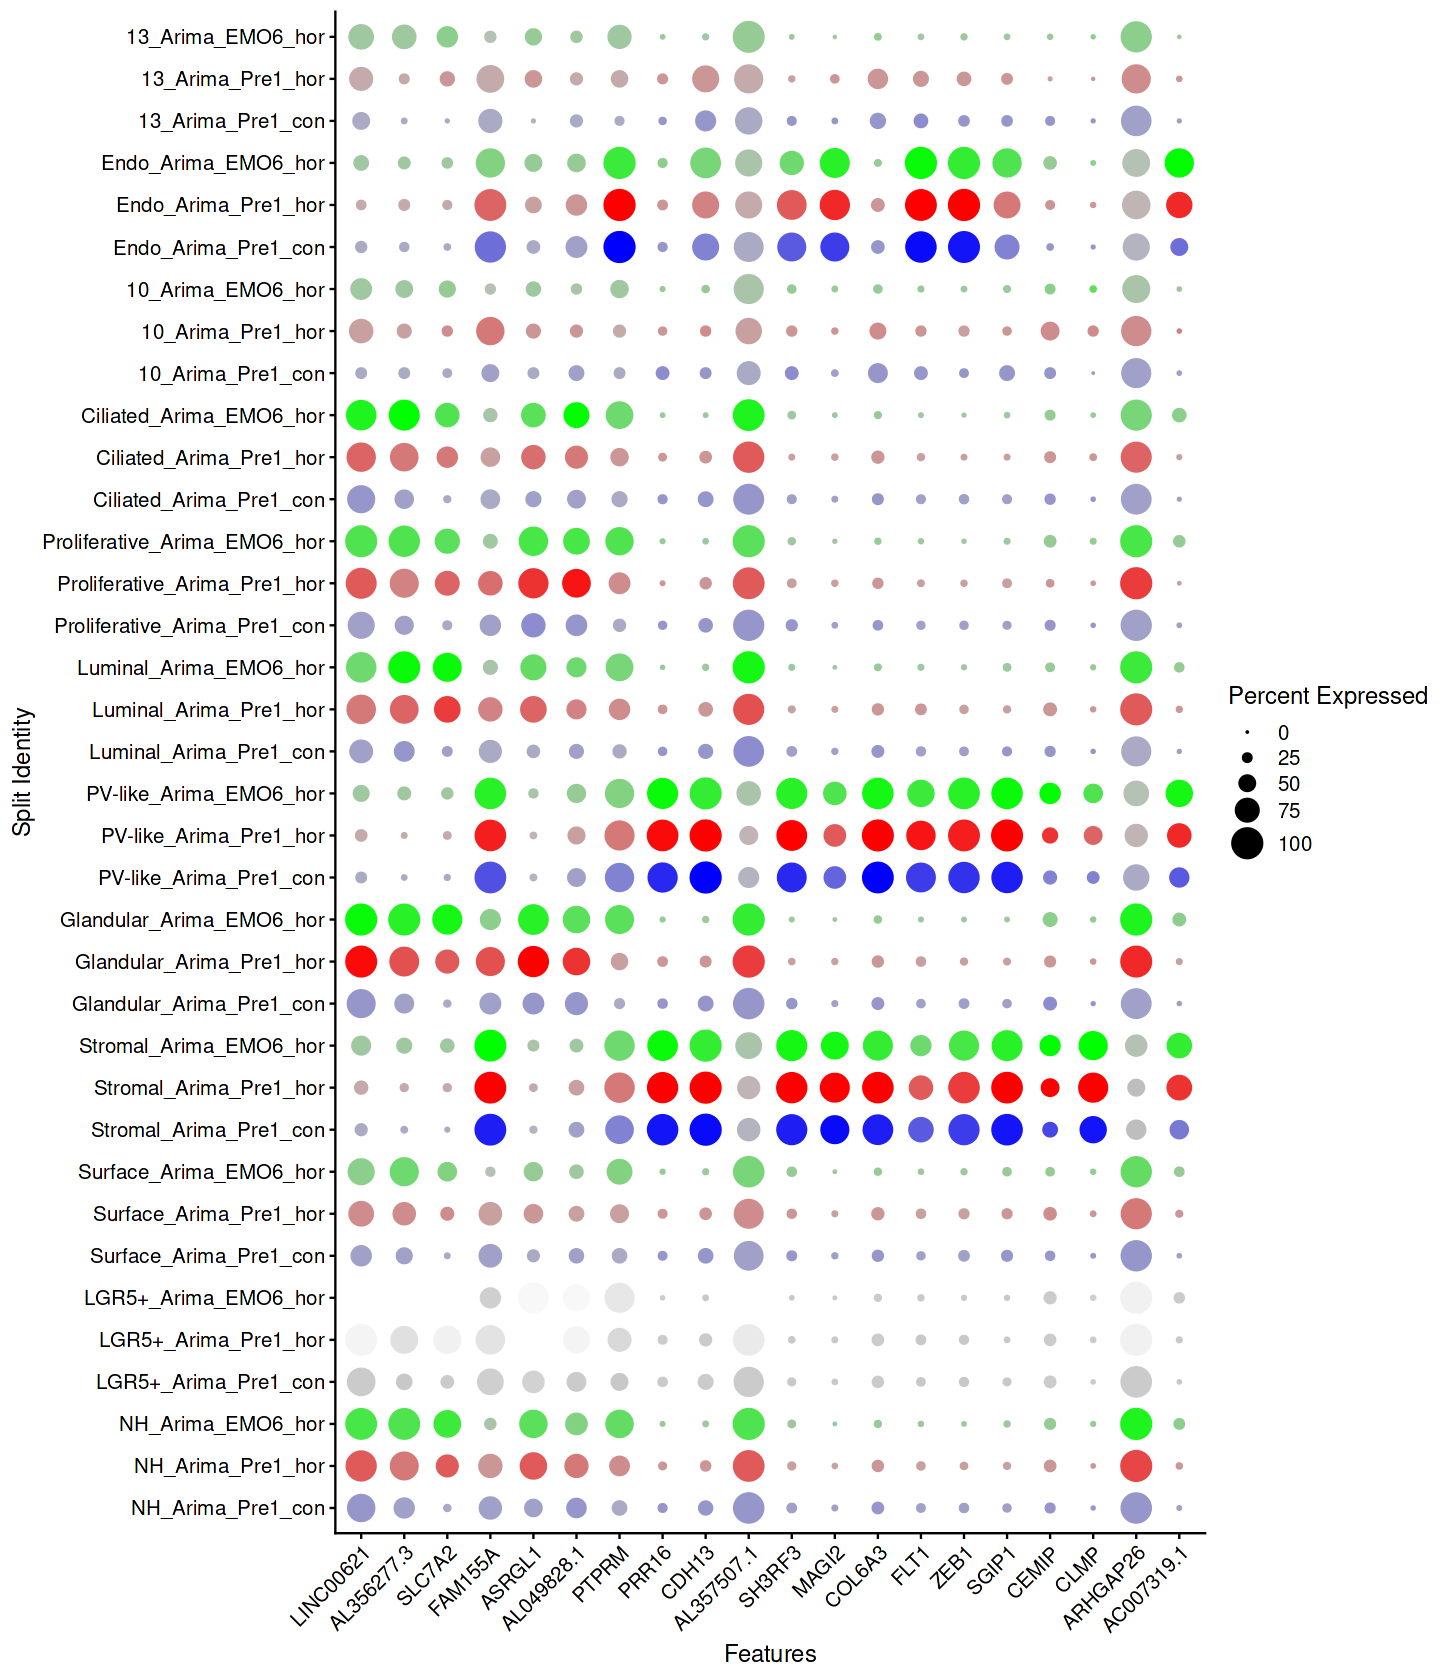

In [34]:
# Dot plots - the size of the dot corresponds to the percentage of cells expressing the
# feature in each cluster. The color represents the average expression level
plot.width = 12
plot.height = 14
options(repr.plot.width = plot.width, repr.plot.height = plot.height)

Idents(ari_org_integrated) <- ari_org_integrated$celltype
DotPlot(ari_org_integrated, features = markers2$genes, cols = c("blue", "red", "green"), dot.scale = 8, split.by = "sample") +
    RotatedAxis()
ggsave(file="results/2023-07-06_Revision1/ari_org_hor_markers_Hor_vs_Con_Pre1_only_dotplot.pdf", width = plot.width, height = plot.height)

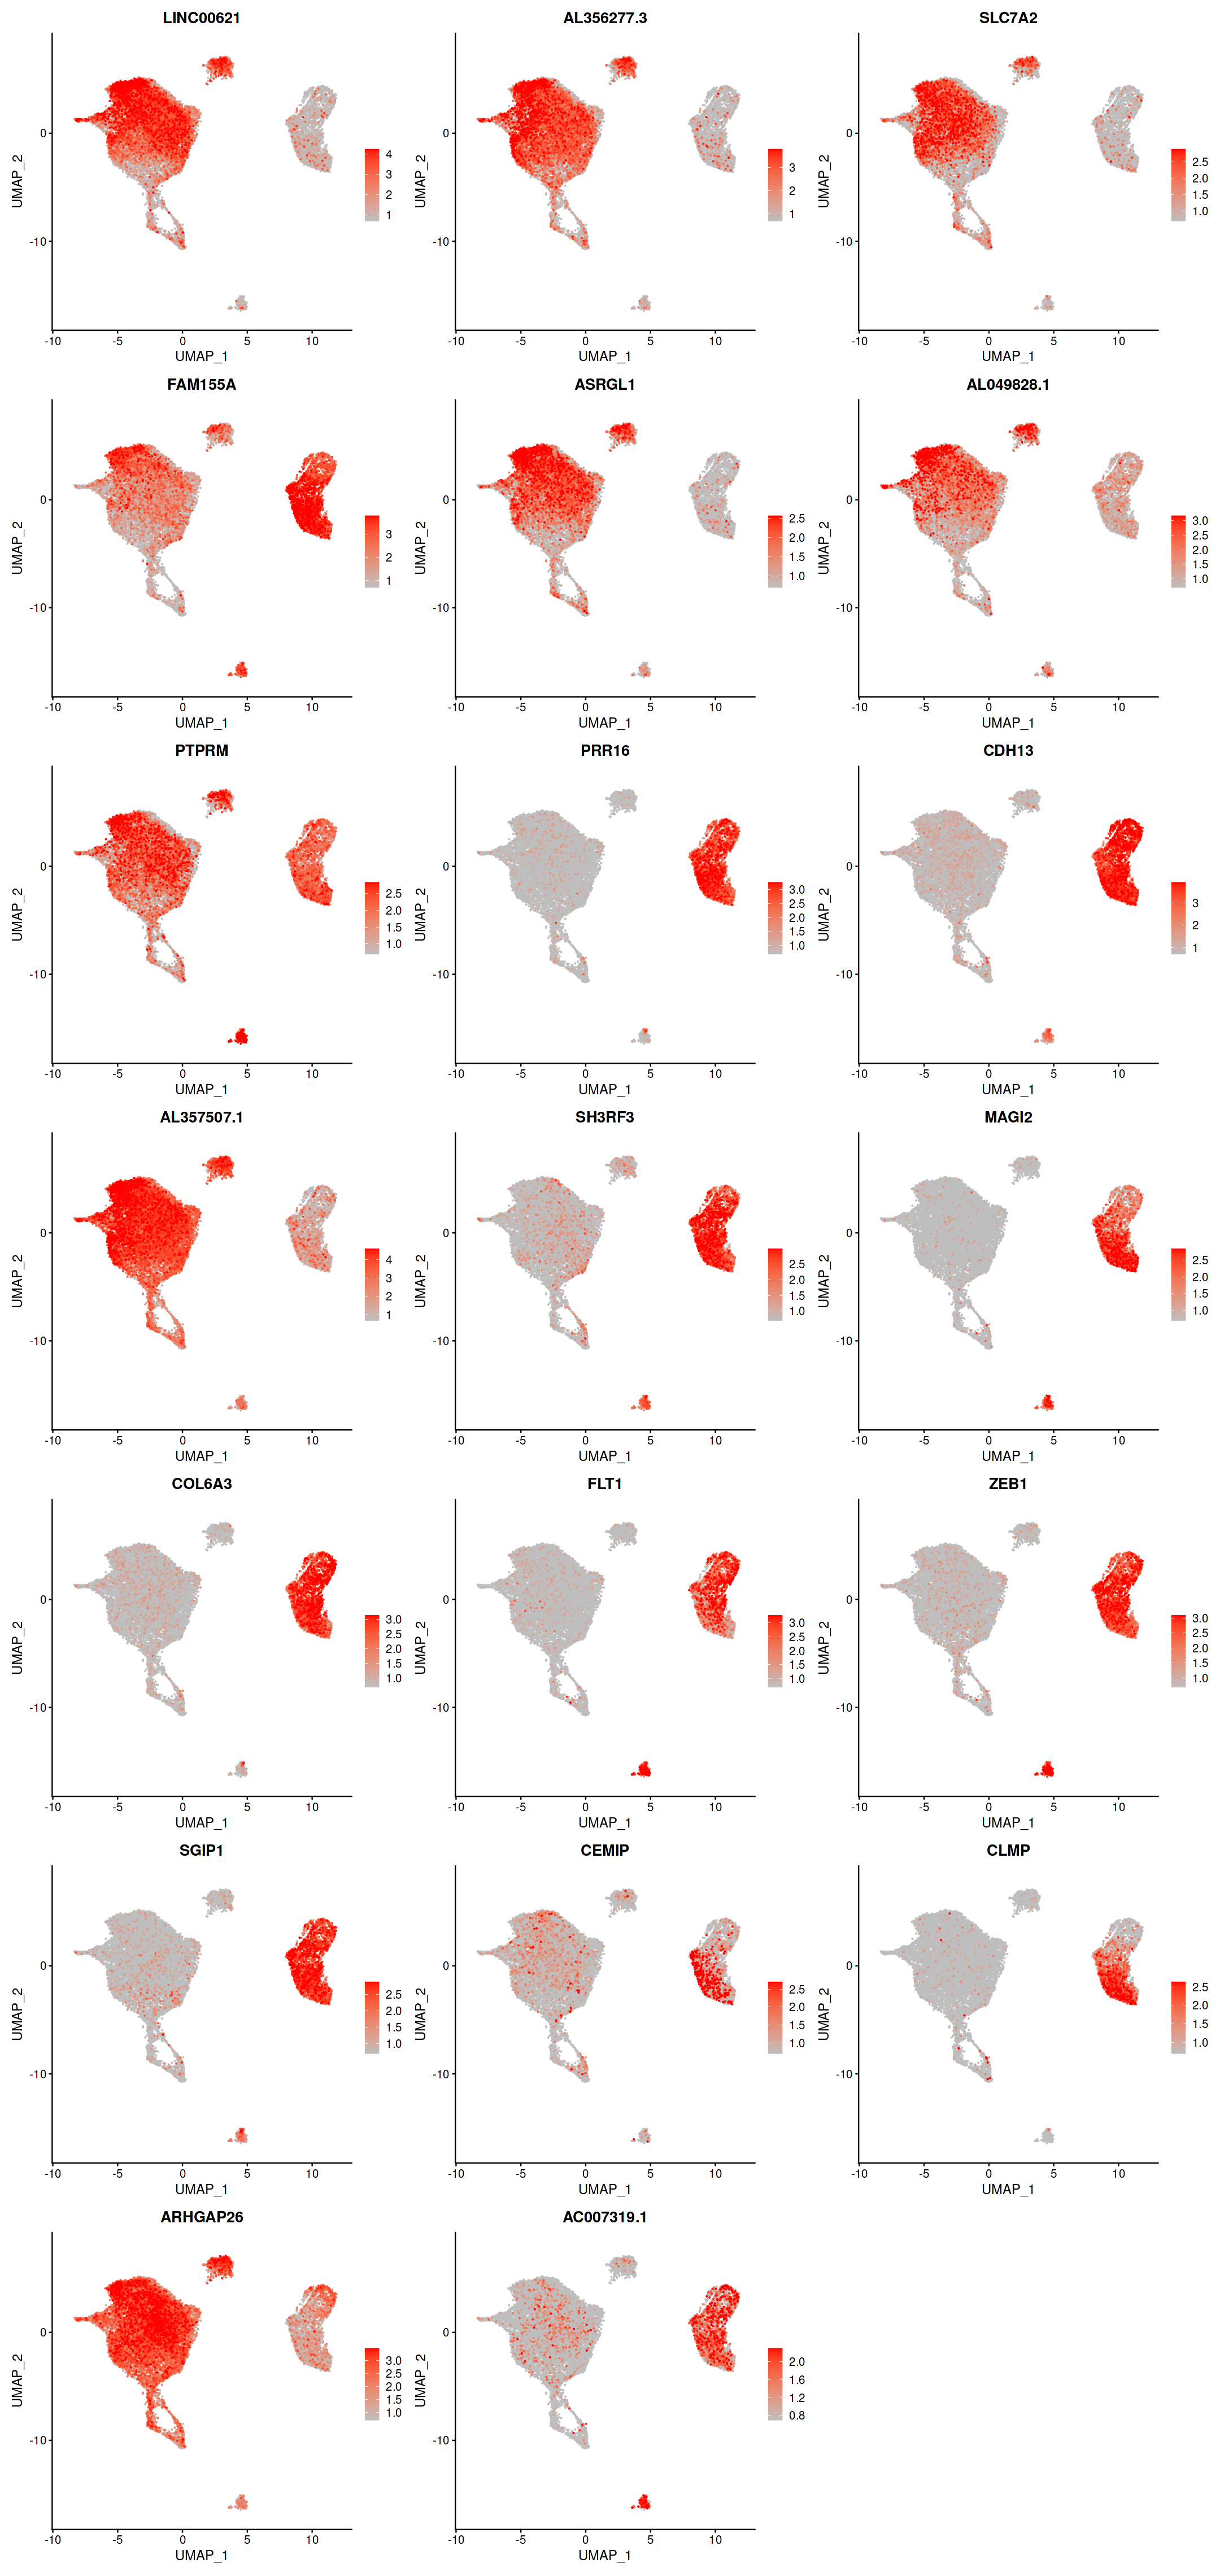

In [35]:
# markers to plot
plot.width = 18
plot.height = 38
options(repr.plot.width = plot.width, repr.plot.height = plot.height)
FeaturePlot(ari_org_integrated, features = markers2$genes, order = TRUE, 
            min.cutoff = 'q5', max.cutoff = 'q95', ncol = 3, cols = c("low" = "grey", "high" = "red"))
ggsave(file="results/2023-07-06_Revision1/ari_org_hor_markers_Hor_vs_Con_Pre1_only_umap.pdf", width = plot.width, height = plot.height)

When using repel, set xnudge and ynudge to 0 for optimal results



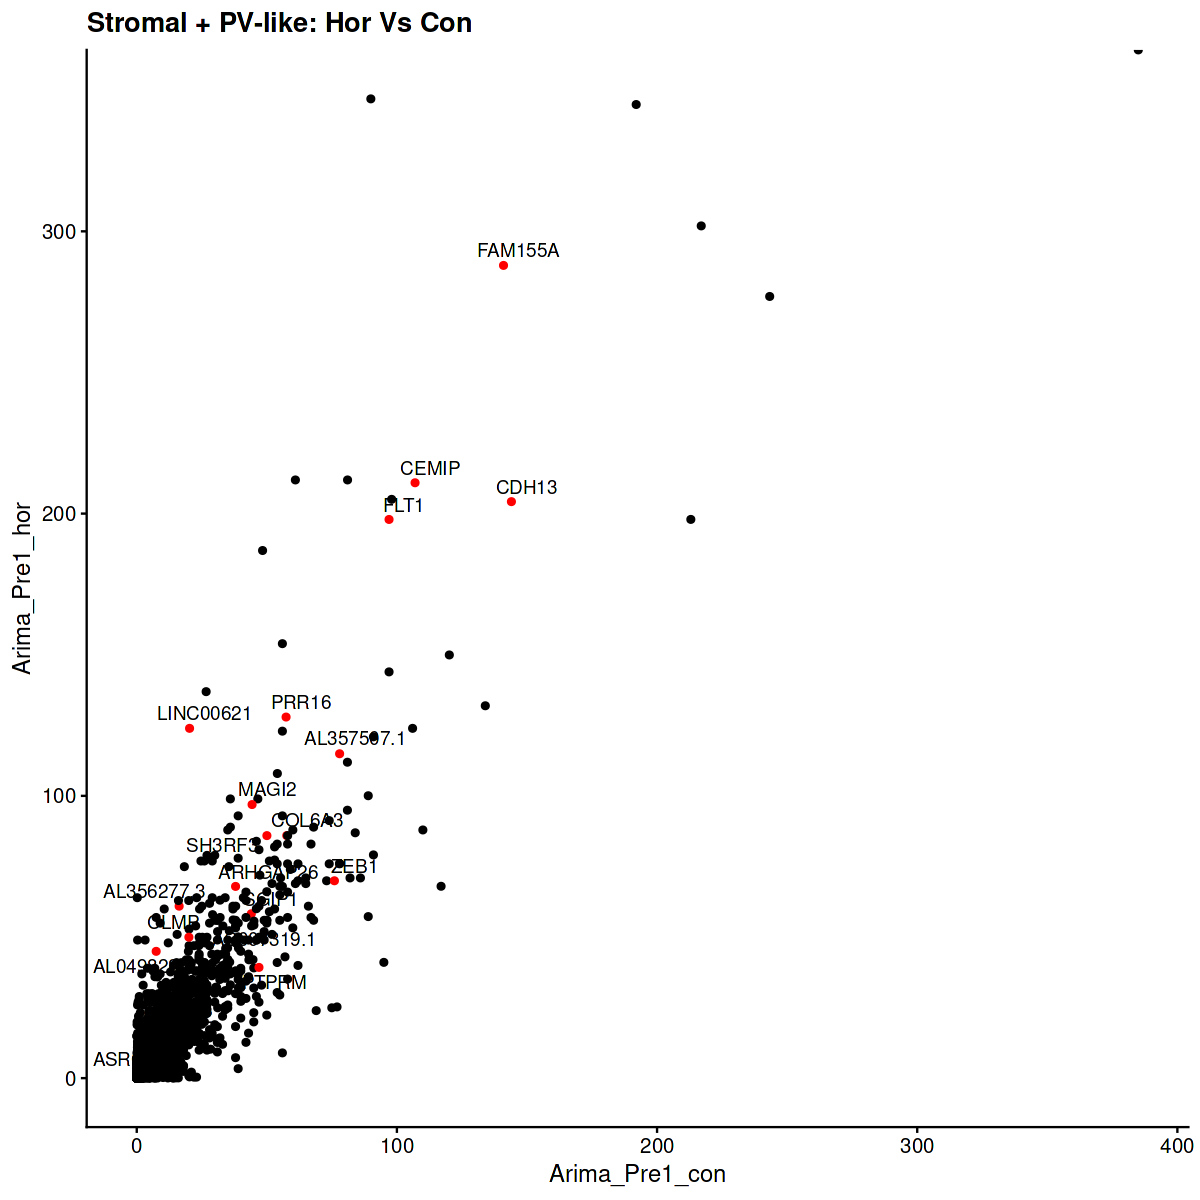

In [36]:
# genes come from previous step
genes.to.label = head(row.names(markers2), 20)
theme_set(theme_cowplot())

Idents(ari_org_integrated) <- ari_org_integrated$celltype
stromal.cells <- subset(ari_org_integrated, idents = c("Stromal", "PV-like"))

Idents(stromal.cells) <- "sample"
avg.stromal.cells <- as.data.frame(log1p(AverageExpression(stromal.cells, verbose = FALSE)$RNA))
avg.stromal.cells$gene <- rownames(avg.stromal.cells)

plot.width = 10
plot.height = 10
options(repr.plot.width = plot.width, repr.plot.height = plot.height)
p1 <- ggplot(avg.stromal.cells, aes(Arima_Pre1_con, Arima_Pre1_hor)) + 
        geom_point(aes(color = gene %in% genes.to.label)) +
        scale_color_manual(values = c("FALSE" = "black", "TRUE" = "red")) +
        ggtitle("Stromal + PV-like: Hor Vs Con") + NoLegend()
p1 <- LabelPoints(plot = p1, points = genes.to.label, repel = TRUE)
p1
ggsave(file="results/2023-07-06_Revision1/ari_org_hor_markers_Hor_vs_Con_Pre1_only_scatter.pdf", width = plot.width, height = plot.height)

### Isolate only Stromal and PV-like cells

In [37]:
# Doing in a different way 

# Define the cell types of interest
cell_types <- c("Stromal", "PV-like")

# Perform differential expression analysis
Idents(object = ari_org_integrated) <- ari_org_integrated$sample
DefaultAssay(ari_org_integrated) <- "SCT"
DEGs_hor_stromal_pv <- FindMarkers(ari_org_integrated, ident.1 = "Arima_Pre1_hor", ident.2 = "Arima_Pre1_con", 
                          logfc.threshold = 0.25, min.pct = 0.1, 
                          assay = "SCT", only.pos = TRUE, subset.ident = cell_types)

In [38]:
#DEGs_hor_stromal_pv
DEGs_hor_stromal_pv$genes <- rownames(DEGs_hor_stromal_pv)

head(DEGs_hor_stromal_pv, 20)

p_val         avg_log2FC pct.1 pct.2 p_val_adj     genes     
SLC7A2     1.950476e-271 1.2888371  0.475 0.183 5.370246e-267 SLC7A2    
HIF1A-AS3  7.427239e-241 0.7969823  0.730 0.467 2.044942e-236 HIF1A-AS3 
ALKAL2     4.721087e-240 0.4655754  0.258 0.044 1.299857e-235 ALKAL2    
PTGS2      1.649597e-235 0.3897094  0.202 0.021 4.541837e-231 PTGS2     
PTPRM      5.576468e-217 1.0052894  0.721 0.489 1.535369e-212 PTPRM     
USP53      8.751970e-200 0.7932855  0.839 0.667 2.409680e-195 USP53     
HIF1A      9.472969e-194 0.6257092  0.902 0.781 2.608192e-189 HIF1A     
FAM155A    1.474537e-186 1.2105208  0.851 0.744 4.059841e-182 FAM155A   
STC1       2.767406e-184 0.7750814  0.566 0.308 7.619499e-180 STC1      
MT2A       7.908901e-182 0.3025502  0.195 0.032 2.177558e-177 MT2A      
GREB1      2.794278e-177 0.6400669  0.294 0.091 7.693487e-173 GREB1     
PKHD1L1    1.759919e-169 0.6714685  0.122 0.006 4.845585e-165 PKHD1L1   
CPM        1.651233e-168 0.3913233  0.164 0.022 4.546340e-164 CPM       
PGR        6.449352e-164 0.3719798  0.193 0.037 1.775700e-159 PGR       
STARD13-AS 6.950157e-164 0.5373100  0.385 0.162 1.913587e-159 STARD13-AS
NXNL2      4.754767e-162 0.4292325  0.302 0.102 1.309130e-157 NXNL2     
AL513327.1 5.520320e-156 0.6369323  0.456 0.235 1.519910e-151 AL513327.1
ATP6V1C2   7.924700e-156 0.4558168  0.249 0.072 2.181908e-151 ATP6V1C2  
AC007319.1 1.208283e-154 0.7986688  0.367 0.155 3.326766e-150 AC007319.1
LINC00513  2.992990e-154 0.5665486  0.475 0.247 8.240600e-150 LINC00513

In [70]:
# markers to plot
markers3 = DEGs_hor_stromal_pv %>%
    head(n = 20)
markers3

p_val         avg_log2FC pct.1 pct.2 p_val_adj     genes     
SLC7A2     1.950476e-271 1.2888371  0.475 0.183 5.370246e-267 SLC7A2    
HIF1A-AS3  7.427239e-241 0.7969823  0.730 0.467 2.044942e-236 HIF1A-AS3 
ALKAL2     4.721087e-240 0.4655754  0.258 0.044 1.299857e-235 ALKAL2    
PTGS2      1.649597e-235 0.3897094  0.202 0.021 4.541837e-231 PTGS2     
PTPRM      5.576468e-217 1.0052894  0.721 0.489 1.535369e-212 PTPRM     
USP53      8.751970e-200 0.7932855  0.839 0.667 2.409680e-195 USP53     
HIF1A      9.472969e-194 0.6257092  0.902 0.781 2.608192e-189 HIF1A     
FAM155A    1.474537e-186 1.2105208  0.851 0.744 4.059841e-182 FAM155A   
STC1       2.767406e-184 0.7750814  0.566 0.308 7.619499e-180 STC1      
MT2A       7.908901e-182 0.3025502  0.195 0.032 2.177558e-177 MT2A      
GREB1      2.794278e-177 0.6400669  0.294 0.091 7.693487e-173 GREB1     
PKHD1L1    1.759919e-169 0.6714685  0.122 0.006 4.845585e-165 PKHD1L1   
CPM        1.651233e-168 0.3913233  0.164 0.022 4.546340e-164 CPM       
PGR        6.449352e-164 0.3719798  0.193 0.037 1.775700e-159 PGR       
STARD13-AS 6.950157e-164 0.5373100  0.385 0.162 1.913587e-159 STARD13-AS
NXNL2      4.754767e-162 0.4292325  0.302 0.102 1.309130e-157 NXNL2     
AL513327.1 5.520320e-156 0.6369323  0.456 0.235 1.519910e-151 AL513327.1
ATP6V1C2   7.924700e-156 0.4558168  0.249 0.072 2.181908e-151 ATP6V1C2  
AC007319.1 1.208283e-154 0.7986688  0.367 0.155 3.326766e-150 AC007319.1
LINC00513  2.992990e-154 0.5665486  0.475 0.247 8.240600e-150 LINC00513

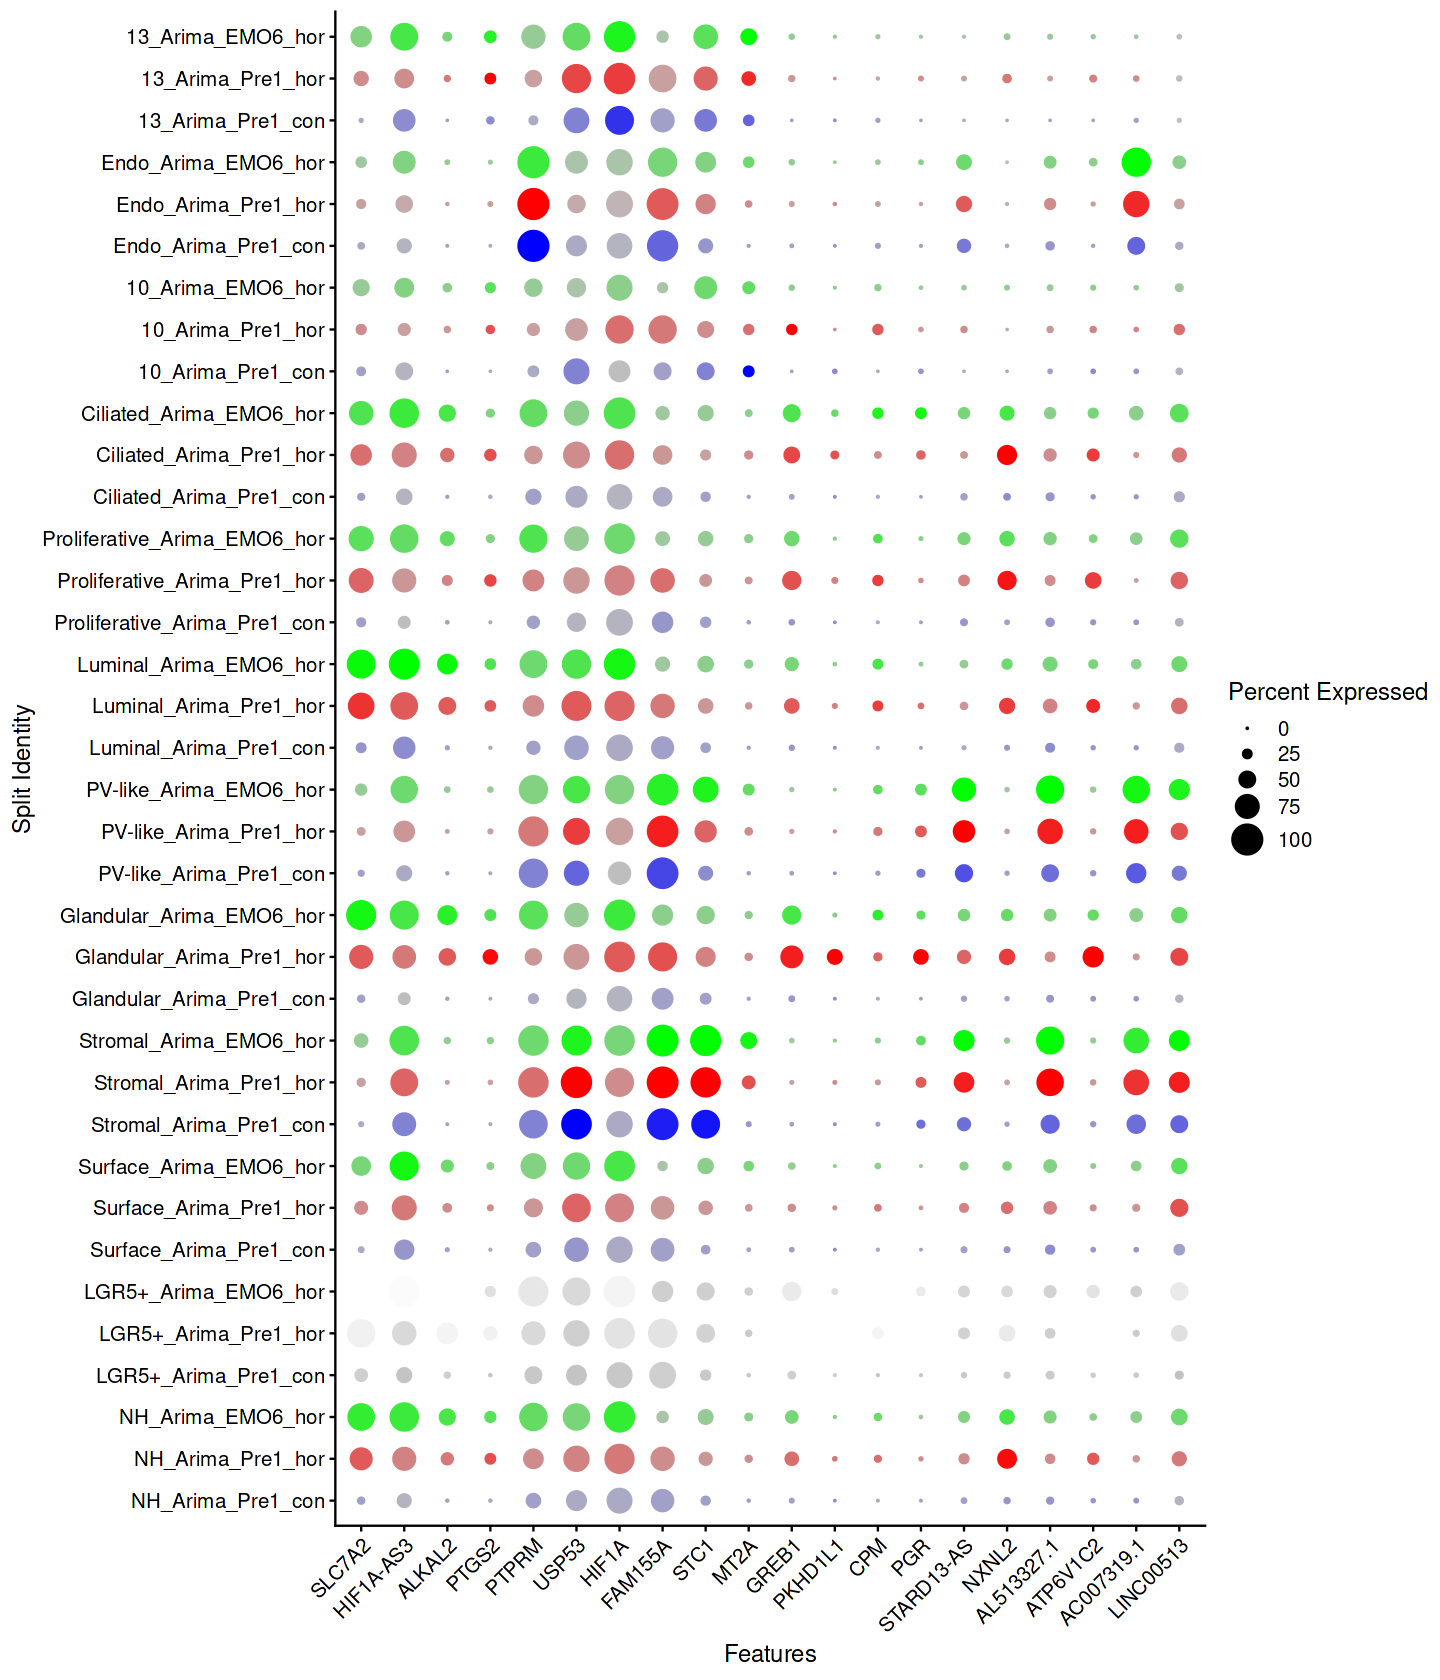

In [71]:
# Dot plots - the size of the dot corresponds to the percentage of cells expressing the
# feature in each cluster. The color represents the average expression level
plot.width = 12
plot.height = 14
options(repr.plot.width = plot.width, repr.plot.height = plot.height)

Idents(ari_org_integrated) <- ari_org_integrated$celltype
DotPlot(ari_org_integrated, features = markers3$genes, cols = c("blue", "red", "green"), dot.scale = 8, split.by = "sample") +
    RotatedAxis()
#ggsave(file="results/2023-04-28/ari_org_dotplot_by_sample_named.pdf", width = plot.width, height = plot.height)

When using repel, set xnudge and ynudge to 0 for optimal results



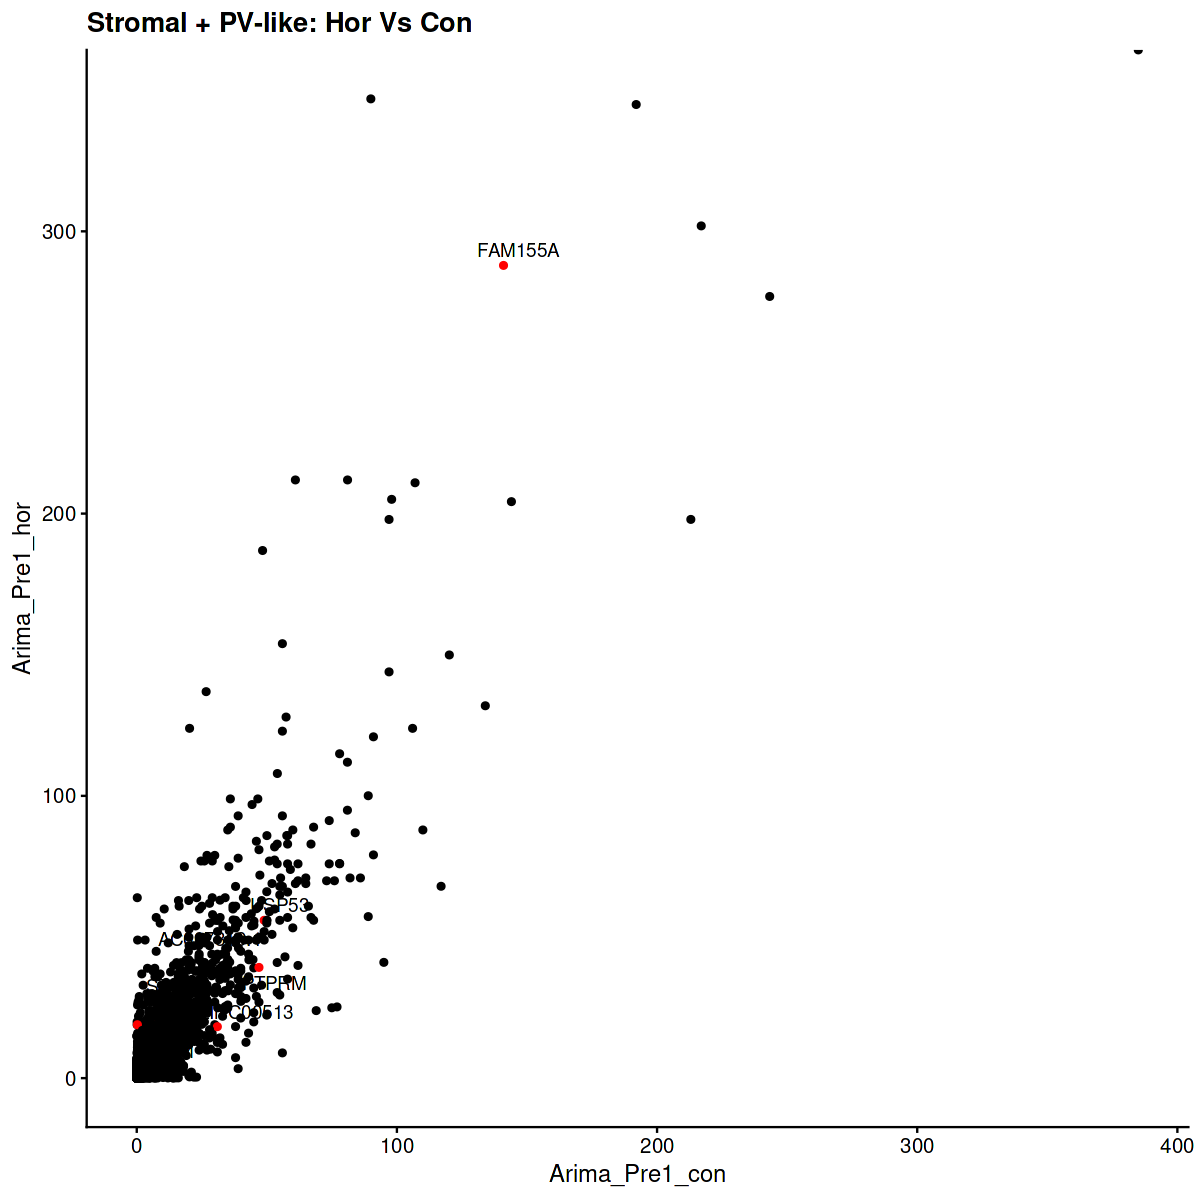

In [81]:
# genes come from previous step
genes.to.label = head(row.names(markers3), 20)
theme_set(theme_cowplot())

Idents(ari_org_integrated) <- ari_org_integrated$celltype
stromal.cells <- subset(ari_org_integrated, idents = c("Stromal", "PV-like"))

Idents(stromal.cells) <- "sample"
avg.stromal.cells <- as.data.frame(log1p(AverageExpression(stromal.cells, verbose = FALSE)$RNA))
avg.stromal.cells$gene <- rownames(avg.stromal.cells)

plot.width = 10
plot.height = 10
options(repr.plot.width = plot.width, repr.plot.height = plot.height)
p1 <- ggplot(avg.stromal.cells, aes(Arima_Pre1_con, Arima_Pre1_hor)) + 
        geom_point(aes(color = gene %in% genes.to.label)) +
        scale_color_manual(values = c("FALSE" = "black", "TRUE" = "red")) +
        ggtitle("Stromal + PV-like: Hor Vs Con") + NoLegend()
p1 <- LabelPoints(plot = p1, points = genes.to.label, repel = TRUE)
p1

### What if we order by the FoldChange?

In [73]:
# markers to plot
markers4 = DEGs_hor_stromal_pv %>%
    slice_max(n = 20, order_by = avg_log2FC)
markers4

p_val         avg_log2FC pct.1 pct.2 p_val_adj     genes     
LINC00621   4.825098e-30 1.5983293  0.698 0.728  1.328494e-25 LINC00621 
AL356277.3  4.152646e-96 1.5026510  0.582 0.477  1.143348e-91 AL356277.3
SLC7A2     1.950476e-271 1.2888371  0.475 0.183 5.370246e-267 SLC7A2    
FAM155A    1.474537e-186 1.2105208  0.851 0.744 4.059841e-182 FAM155A   
ASRGL1      1.313304e-95 1.0086457  0.571 0.463  3.615919e-91 ASRGL1    
AL049828.1  1.391253e-27 1.0072989  0.596 0.544  3.830538e-23 AL049828.1
PTPRM      5.576468e-217 1.0052894  0.721 0.489 1.535369e-212 PTPRM     
PRR16       3.088634e-64 1.0031990  0.462 0.338  8.503935e-60 PRR16     
CDH13       5.020706e-35 0.9204957  0.566 0.514  1.382351e-30 CDH13     
AL357507.1  1.595683e-14 0.9171943  0.848 0.908  4.393394e-10 AL357507.1
SH3RF3      5.643664e-62 0.9063357  0.473 0.362  1.553870e-57 SH3RF3    
MAGI2       5.340396e-83 0.9035340  0.386 0.233  1.470371e-78 MAGI2     
COL6A3      3.626386e-69 0.9017322  0.542 0.411  9.984528e-65 COL6A3    
FLT1        7.112014e-60 0.8916615  0.457 0.324  1.958151e-55 FLT1      
ZEB1        3.449966e-73 0.8548342  0.499 0.366  9.498792e-69 ZEB1      
SGIP1       1.005490e-69 0.8521473  0.473 0.344  2.768415e-65 SGIP1     
CEMIP       2.057654e-17 0.8420898  0.369 0.296  5.665338e-13 CEMIP     
CLMP       4.214622e-115 0.8358181  0.316 0.141 1.160412e-110 CLMP      
ARHGAP26    1.319433e-45 0.8051769  0.848 0.924  3.632796e-41 ARHGAP26  
AC007319.1 1.208283e-154 0.7986688  0.367 0.155 3.326766e-150 AC007319.1

When using repel, set xnudge and ynudge to 0 for optimal results



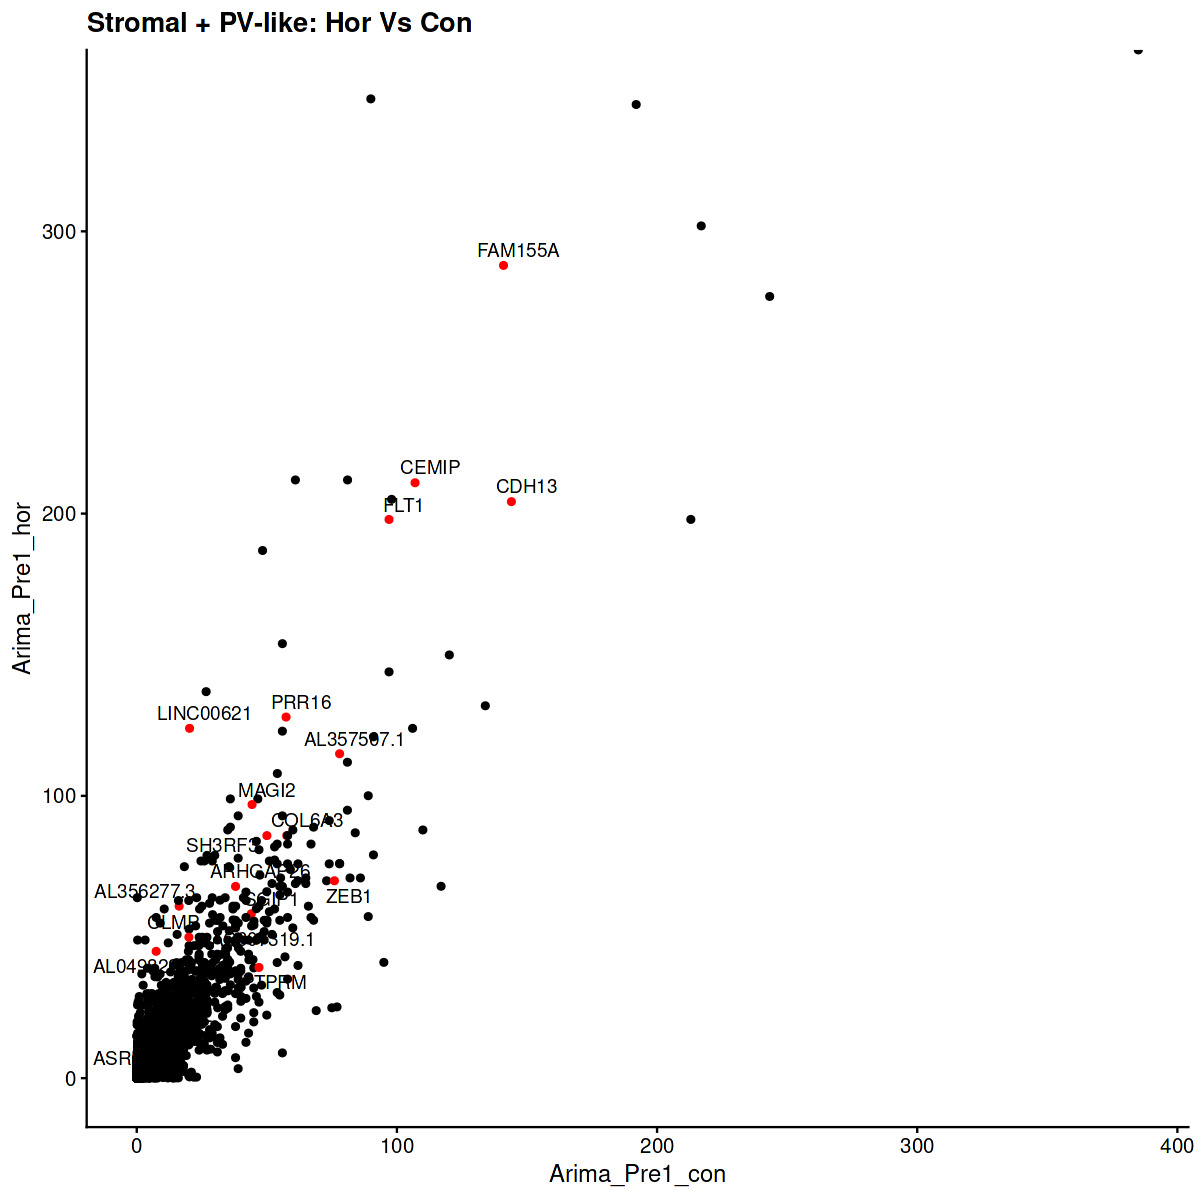

In [80]:
# genes come from previous step
genes.to.label = head(row.names(markers4), 20)
theme_set(theme_cowplot())

Idents(ari_org_integrated) <- ari_org_integrated$celltype
stromal.cells <- subset(ari_org_integrated, idents = c("Stromal", "PV-like"))

Idents(stromal.cells) <- "sample"
avg.stromal.cells <- as.data.frame(log1p(AverageExpression(stromal.cells, verbose = FALSE)$RNA))
avg.stromal.cells$gene <- rownames(avg.stromal.cells)

plot.width = 10
plot.height = 10
options(repr.plot.width = plot.width, repr.plot.height = plot.height)
#p1 <- ggplot(avg.stromal.cells, aes(Arima_Pre1_con, Arima_Pre1_hor)) + 
#        geom_point(color = "red") + ggtitle("Stromal + PV-like: Hor Vs Con")
#p1 <- LabelPoints(plot = p1, points = genes.to.label, repel = TRUE)
#p1


p1 <- ggplot(avg.stromal.cells, aes(Arima_Pre1_con, Arima_Pre1_hor)) + 
        geom_point(aes(color = gene %in% genes.to.label)) +
        scale_color_manual(values = c("FALSE" = "black", "TRUE" = "red")) +
        ggtitle("Stromal + PV-like: Hor Vs Con") + NoLegend()
p1 <- LabelPoints(plot = p1, points = genes.to.label, repel = TRUE)
p1


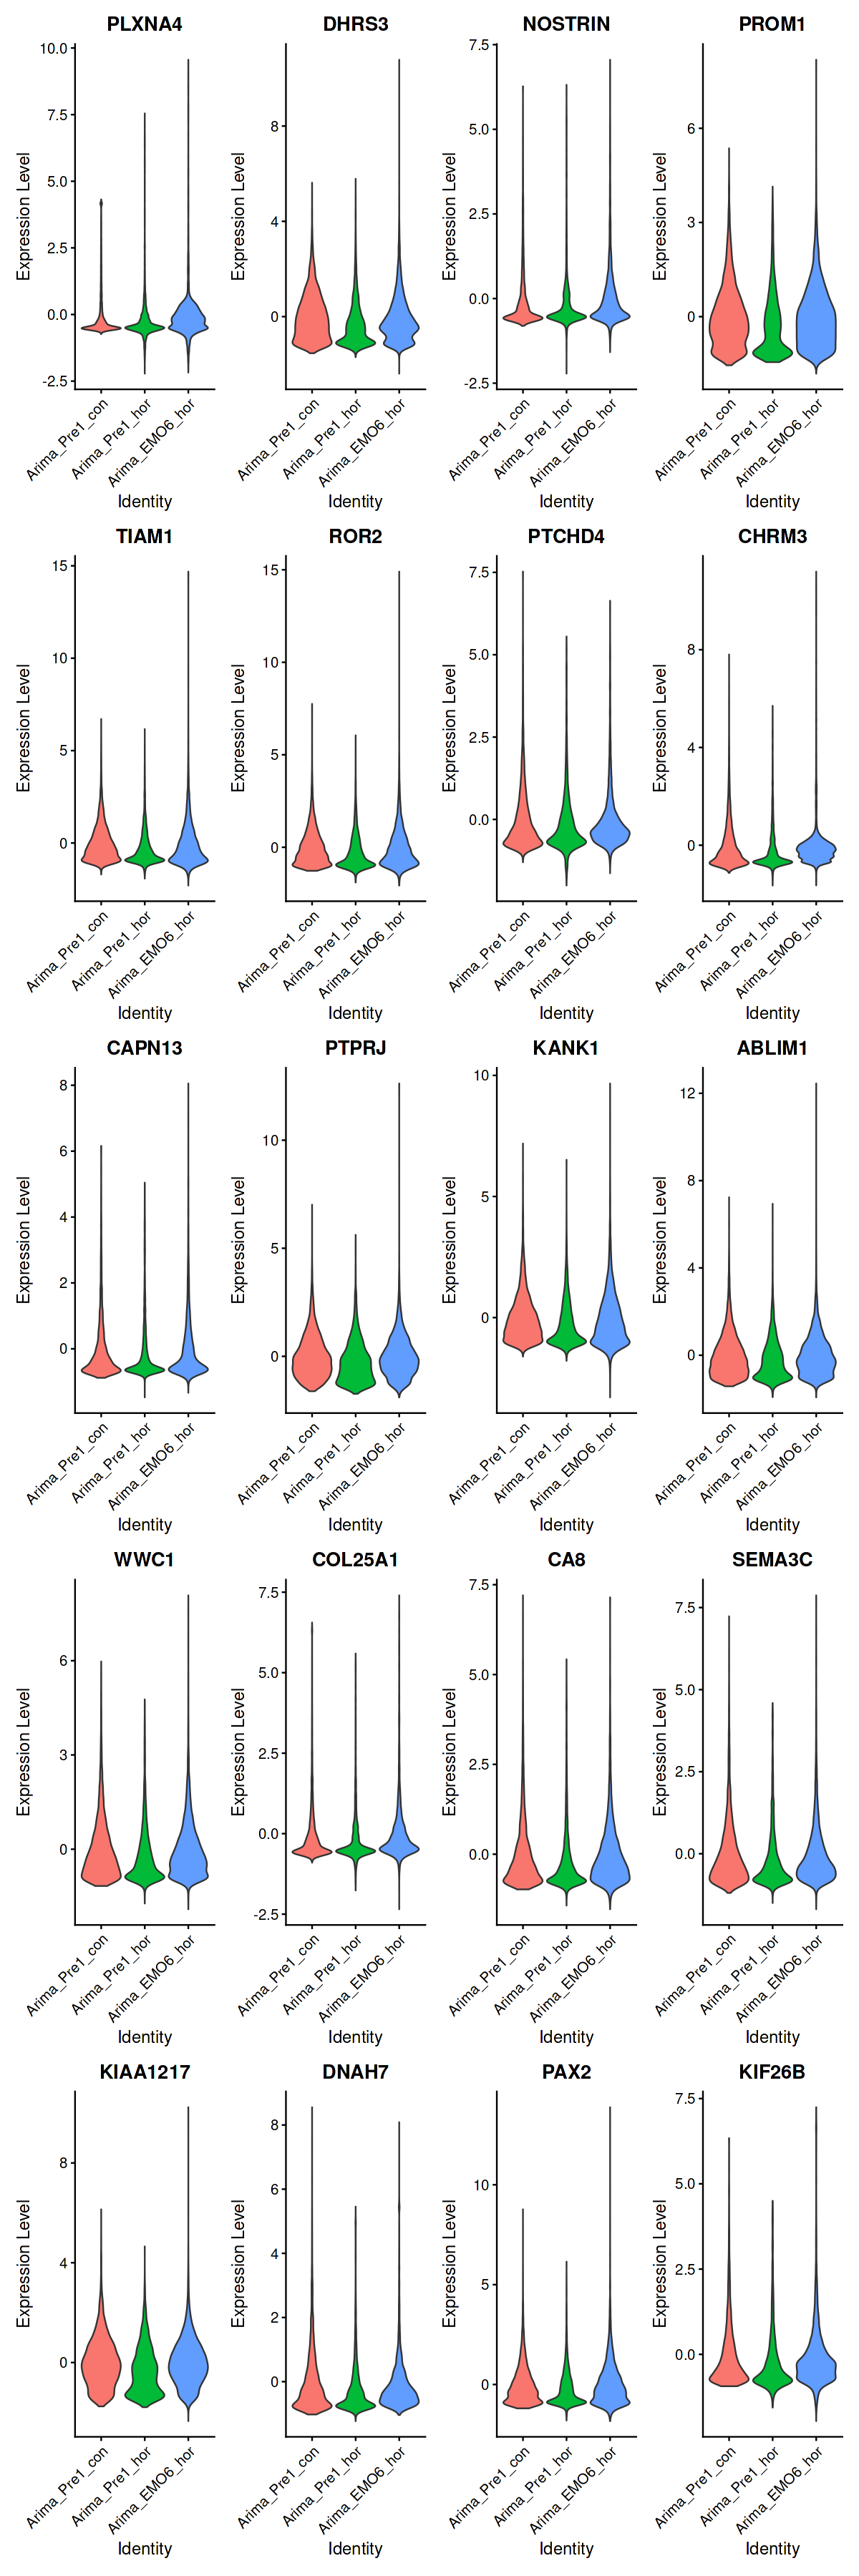

In [148]:
plot.width = 10
plot.height = 30
options(repr.plot.width = plot.width, repr.plot.height = plot.height)
VlnPlot(seuratObj, features = genes.to.label[1:20], pt.size = 0)

In [108]:
sessionInfo()

R version 4.2.2 Patched (2022-11-10 r83330)
Platform: x86_64-pc-linux-gnu (64-bit)
Running under: Ubuntu 20.04.5 LTS

Matrix products: default
BLAS:   /usr/lib/x86_64-linux-gnu/atlas/libblas.so.3.10.3
LAPACK: /usr/lib/x86_64-linux-gnu/atlas/liblapack.so.3.10.3

locale:
 [1] LC_CTYPE=C.UTF-8       LC_NUMERIC=C           LC_TIME=C.UTF-8       
 [4] LC_COLLATE=C.UTF-8     LC_MONETARY=C.UTF-8    LC_MESSAGES=C.UTF-8   
 [7] LC_PAPER=C.UTF-8       LC_NAME=C              LC_ADDRESS=C          
[10] LC_TELEPHONE=C         LC_MEASUREMENT=C.UTF-8 LC_IDENTIFICATION=C   

attached base packages:
[1] stats4    stats     graphics  grDevices utils     datasets  methods  
[8] base     

other attached packages:
 [1] AnnotationHub_3.6.0   BiocFileCache_2.6.0   dbplyr_2.3.0         
 [4] org.Hs.eg.db_3.16.0   AnnotationDbi_1.60.0  IRanges_2.32.0       
 [7] S4Vectors_0.36.1      Biobase_2.58.0        BiocGenerics_0.44.0  
[10] clusterProfiler_4.6.0 dittoSeq_1.10.0       RColorBrewer_1.1-3   
[13] dplyr_